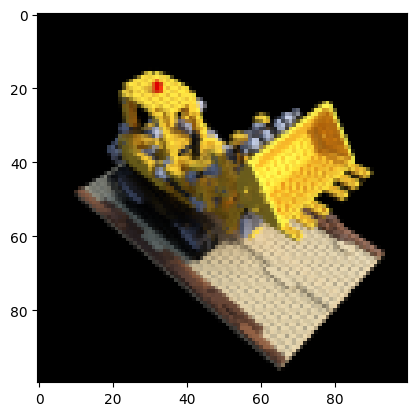

In [1]:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.optim import Adam
import cv2



# Utility Functions (as provided in the initial code)
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    dim = -1
    cumprod = torch.cumprod(tensor, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.
    return cumprod

def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
    ii, jj = meshgrid_xy(
        torch.arange(width).to(tform_cam2world),
        torch.arange(height).to(tform_cam2world)
    )
    directions = torch.stack([(ii - width * .5) / focal_length,
                              -(jj - height * .5) / focal_length,
                              -torch.ones_like(ii)
                             ], dim=-1)
    ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
    return ray_origins, ray_directions

def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: bool = True
) -> (torch.Tensor, torch.Tensor):
    depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
    if randomize:
        noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
        depth_values = depth_values \
            + torch.rand(noise_shape).to(ray_origins) * (far_thresh - near_thresh) / num_samples
    query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
    return query_points, depth_values

def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                       one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
    alpha = 1. - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)
    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)
    return rgb_map, depth_map, acc_map

def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
    encoding = [tensor] if include_input else []
    frequency_bands = None
    if log_sampling:
        frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    else:
        frequency_bands = torch.linspace(
            2.0 ** 0.0,
            2.0 ** (num_encoding_functions - 1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)

# ResNet Block
class ResBlock(nn.Module):
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
    
    def forward(self, x):
        return x + self.block(x)

# Deep NeRF Model with ResNet blocks
class DeepNeRF(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, num_blocks=4):
        super(DeepNeRF, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([ResBlock(hidden_dim) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

# Tone Mapping
def tone_mapping(image):
    return image / (image + 1.0)

# Function to generate random camera poses
def generate_random_pose_y_translation(y_min=-1.0, y_max=1.0):
    random_y_translation = torch.tensor([[0, np.random.uniform(y_min, y_max), 0, 0],
                                         [0, 0, 0, 0],
                                         [0, 0, 0, 0],
                                         [0, 0, 0, 1]]).to(device)
    random_pose = torch.eye(4).to(device) + random_y_translation
    return random_pose



# Render a novel view using a random camera pose
def render_novel_view(coarse_model, fine_model, pose):
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, pose)
    
    # Compute query points for both coarse and fine networks
    coarse_query_points, coarse_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_coarse_samples, randomize=True
    )
    fine_query_points, fine_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_fine_samples, randomize=False
    )

    # Flatten and encode the query points
    coarse_query_points_flat = coarse_query_points.reshape((-1, 3))
    coarse_encoded_points = positional_encoding(coarse_query_points_flat)
    fine_query_points_flat = fine_query_points.reshape((-1, 3))
    fine_encoded_points = positional_encoding(fine_query_points_flat)

    # Forward pass through the coarse and fine networks
    coarse_radiance_field = coarse_model(coarse_encoded_points)
    fine_radiance_field = fine_model(fine_encoded_points)

    # Compute the rendered RGB maps, depth maps, and accumulation maps using the correct depth values
    coarse_rgb_map, _, coarse_acc_map = render_volume_density(
        coarse_radiance_field.reshape(tuple(coarse_query_points.shape[:-1]) + (4,)),
        ray_origins,
        coarse_depth_values
    )
    fine_rgb_map, _, _ = render_volume_density(
        fine_radiance_field.reshape(tuple(fine_query_points.shape[:-1]) + (4,)),
        ray_origins,
        fine_depth_values
    )

    # Combine the coarse and fine RGB maps
    rgb_map = coarse_rgb_map * (1. - coarse_acc_map[..., None]) + fine_rgb_map

    return rgb_map

def pose_loss_fn(rendered_img, target_img):
    return ((rendered_img - target_img) ** 2).mean()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(testimg.detach().cpu().numpy())
plt.show()

# Parameters for TinyNeRF training
num_encoding_functions = 6
input_dim = 3 + 3 * 2 * num_encoding_functions
output_dim = 4
lr = 1e-4
num_iters = 30000
num_coarse_samples = 64
num_fine_samples = 128
batch_fraction = 0.1  # Process 10% of the image at a time
batch_size = 32  # Define a suitable batch size

# Setting up for pose estimation
target_img_index = 9  # Python uses 0-based indexing, so the 10th image is at index 9

initial_pose = generate_random_pose_y_translation().requires_grad_(True)
pose_optimizer = Adam([initial_pose], lr=0.01)
num_pose_optimization_steps = 1000  # You can adjust this value

# Instantiate the Coarse and Fine DeepNeRF networks
coarse_net = DeepNeRF(input_dim=input_dim, output_dim=output_dim).to(device)
fine_net = DeepNeRF(input_dim=input_dim, output_dim=output_dim).to(device)

# Optimizer
optimizer = torch.optim.Adam(list(coarse_net.parameters()) + list(fine_net.parameters()), lr=lr)


# Lists to store PSNR values and iteration numbers for plotting
psnr_values = []
iterations = []
losses = []  # to store losses for visualization







c:\Users\gaura\.conda\envs\mynerf\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0: Loss 0.13810041546821594, Time per iter: 2.81s, Estimated time remaining: 84206.56s


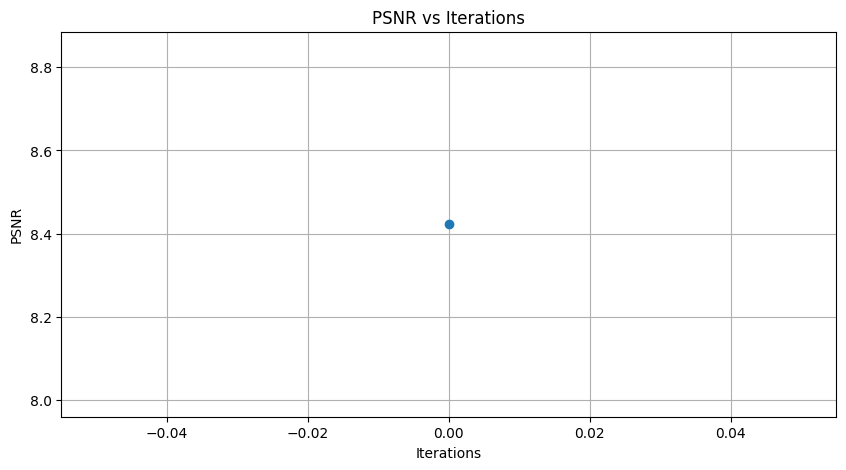

Iteration 100: Loss 0.027341267094016075, Time per iter: 33.17s, Estimated time remaining: 991866.30s
Iteration 200: Loss 0.027100495994091034, Time per iter: 15.44s, Estimated time remaining: 459965.37s
Iteration 300: Loss 0.018117476254701614, Time per iter: 14.90s, Estimated time remaining: 442424.18s
Iteration 400: Loss 0.030840765684843063, Time per iter: 15.51s, Estimated time remaining: 459161.73s
Iteration 500: Loss 0.014408178627490997, Time per iter: 15.49s, Estimated time remaining: 457068.66s


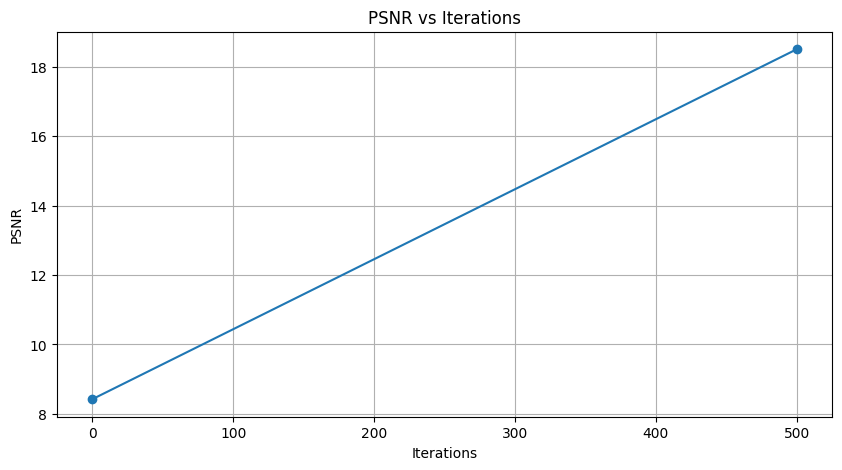

Iteration 600: Loss 0.011635255068540573, Time per iter: 29.10s, Estimated time remaining: 855505.31s
Iteration 700: Loss 0.011297978460788727, Time per iter: 15.58s, Estimated time remaining: 456598.26s
Iteration 800: Loss 0.017969602718949318, Time per iter: 15.67s, Estimated time remaining: 457590.41s
Iteration 900: Loss 0.00755266984924674, Time per iter: 15.74s, Estimated time remaining: 457902.86s
Iteration 1000: Loss 0.010452194139361382, Time per iter: 15.75s, Estimated time remaining: 456771.92s


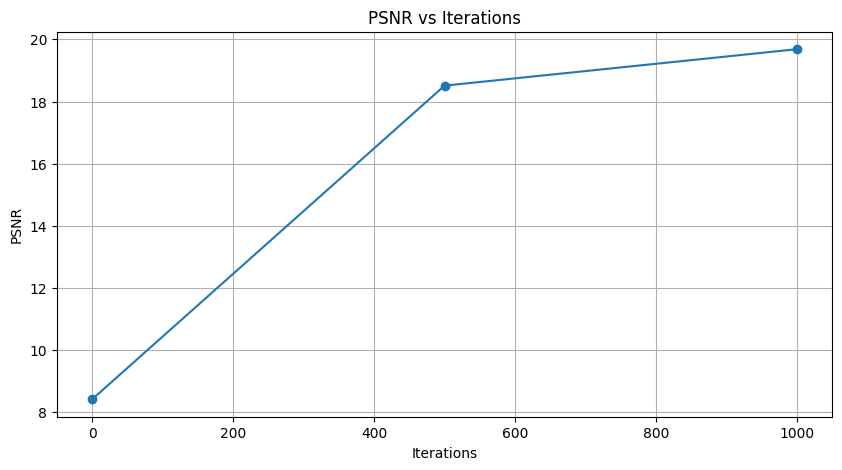

Iteration 1100: Loss 0.007003200240433216, Time per iter: 29.48s, Estimated time remaining: 852006.18s
Iteration 1200: Loss 0.01110176369547844, Time per iter: 16.43s, Estimated time remaining: 473208.63s
Iteration 1300: Loss 0.014632239006459713, Time per iter: 17.68s, Estimated time remaining: 507428.75s
Iteration 1400: Loss 0.0036380484234541655, Time per iter: 17.16s, Estimated time remaining: 490898.12s
Iteration 1500: Loss 0.006133119575679302, Time per iter: 16.86s, Estimated time remaining: 480536.54s


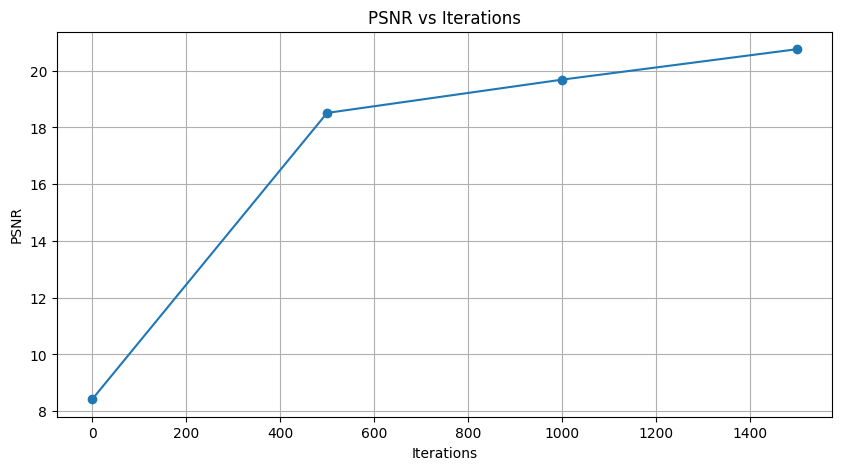

Iteration 1600: Loss 0.008022777736186981, Time per iter: 29.65s, Estimated time remaining: 842089.27s
Iteration 1700: Loss 0.010579433292150497, Time per iter: 16.05s, Estimated time remaining: 454327.73s
Iteration 1800: Loss 0.00757598876953125, Time per iter: 16.12s, Estimated time remaining: 454554.95s
Iteration 1900: Loss 0.009861299768090248, Time per iter: 16.61s, Estimated time remaining: 466818.24s
Iteration 2000: Loss 0.004400523379445076, Time per iter: 16.45s, Estimated time remaining: 460522.93s


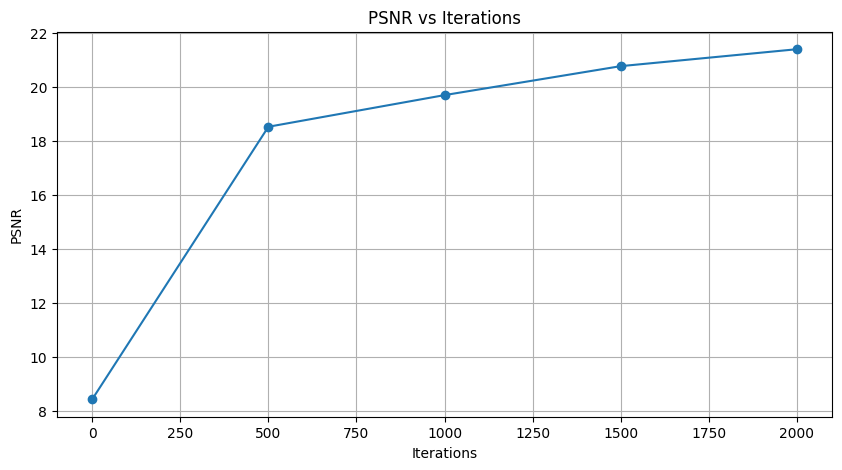

Iteration 2100: Loss 0.008883281610906124, Time per iter: 30.44s, Estimated time remaining: 849377.74s
Iteration 2200: Loss 0.007928342558443546, Time per iter: 16.43s, Estimated time remaining: 456776.64s
Iteration 2300: Loss 0.006680989172309637, Time per iter: 16.63s, Estimated time remaining: 460771.66s
Iteration 2400: Loss 0.0038373356219381094, Time per iter: 16.38s, Estimated time remaining: 452122.20s
Iteration 2500: Loss 0.009734505787491798, Time per iter: 16.35s, Estimated time remaining: 449493.83s


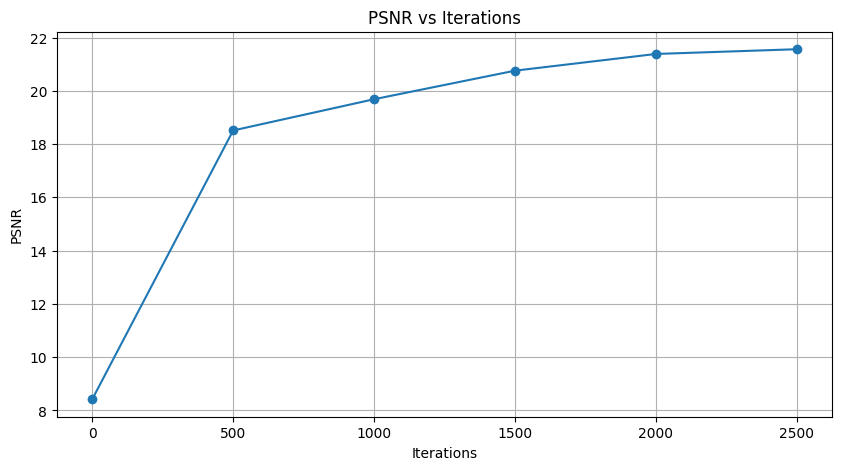

Iteration 2600: Loss 0.006344976834952831, Time per iter: 29.69s, Estimated time remaining: 813372.57s
Iteration 2700: Loss 0.003964367788285017, Time per iter: 16.28s, Estimated time remaining: 444359.87s
Iteration 2800: Loss 0.003191669238731265, Time per iter: 16.32s, Estimated time remaining: 443840.87s
Iteration 2900: Loss 0.004561088979244232, Time per iter: 16.32s, Estimated time remaining: 442315.33s
Iteration 3000: Loss 0.00637446902692318, Time per iter: 16.32s, Estimated time remaining: 440692.37s


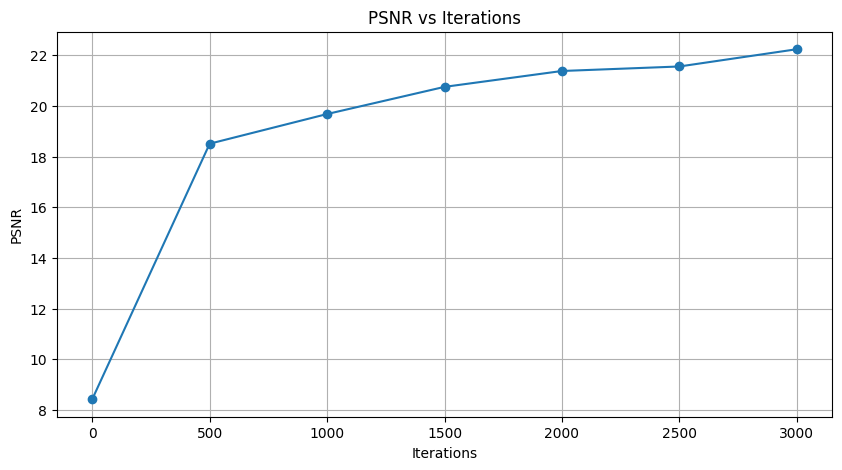

Iteration 3100: Loss 0.005077235400676727, Time per iter: 29.92s, Estimated time remaining: 804905.96s
Iteration 3200: Loss 0.005897084251046181, Time per iter: 16.28s, Estimated time remaining: 436426.74s
Iteration 3300: Loss 0.004652039613574743, Time per iter: 16.30s, Estimated time remaining: 435195.99s
Iteration 3400: Loss 0.005998735781759024, Time per iter: 16.31s, Estimated time remaining: 433975.89s
Iteration 3500: Loss 0.005699498113244772, Time per iter: 16.31s, Estimated time remaining: 432280.42s


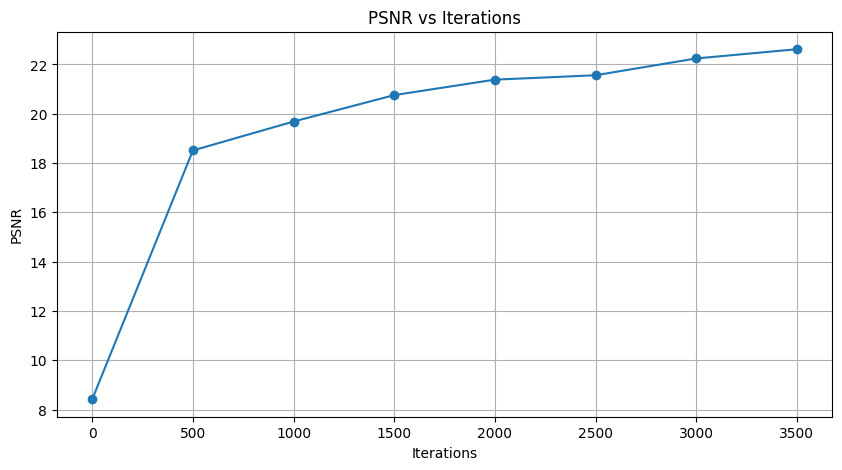

Iteration 3600: Loss 0.0031996555626392365, Time per iter: 29.72s, Estimated time remaining: 784567.57s
Iteration 3700: Loss 0.0074403174221515656, Time per iter: 16.44s, Estimated time remaining: 432499.36s
Iteration 3800: Loss 0.0042556170374155045, Time per iter: 16.44s, Estimated time remaining: 430683.68s
Iteration 3900: Loss 0.003556513227522373, Time per iter: 16.43s, Estimated time remaining: 428809.65s
Iteration 4000: Loss 0.007577221840620041, Time per iter: 16.41s, Estimated time remaining: 426730.46s


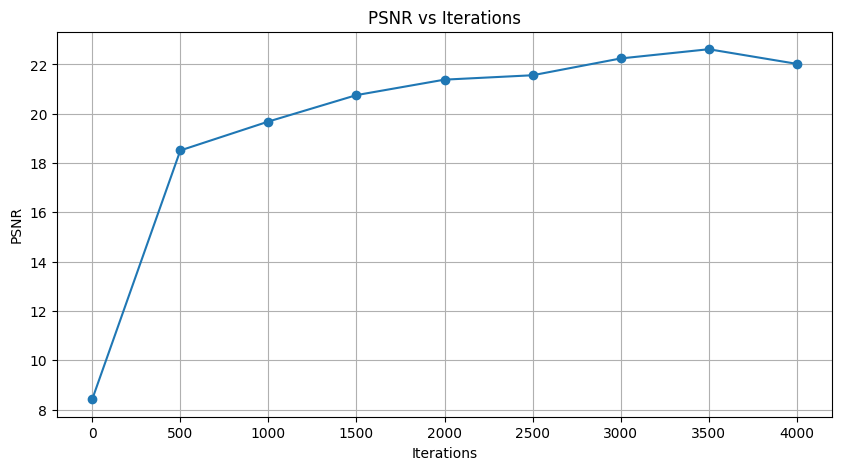

Iteration 4100: Loss 0.004567943979054689, Time per iter: 29.87s, Estimated time remaining: 773606.16s
Iteration 4200: Loss 0.005540378391742706, Time per iter: 16.38s, Estimated time remaining: 422677.56s
Iteration 4300: Loss 0.005569250788539648, Time per iter: 16.62s, Estimated time remaining: 427026.41s
Iteration 4400: Loss 0.003473326563835144, Time per iter: 16.58s, Estimated time remaining: 424533.52s
Iteration 4500: Loss 0.007361508905887604, Time per iter: 16.55s, Estimated time remaining: 422149.86s


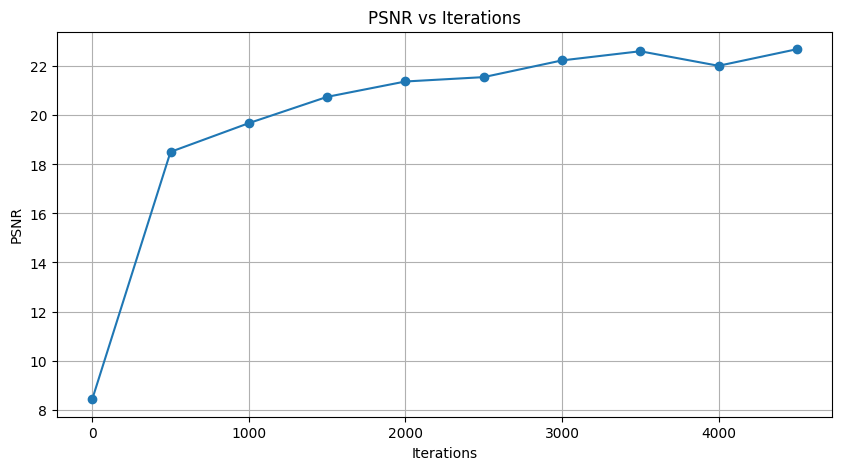

Iteration 4600: Loss 0.0028770440258085728, Time per iter: 30.37s, Estimated time remaining: 771337.66s
Iteration 4700: Loss 0.003992060199379921, Time per iter: 16.53s, Estimated time remaining: 418116.37s
Iteration 4800: Loss 0.006066831760108471, Time per iter: 16.49s, Estimated time remaining: 415659.90s
Iteration 4900: Loss 0.0022829649969935417, Time per iter: 16.47s, Estimated time remaining: 413378.75s
Iteration 5000: Loss 0.0062882318161427975, Time per iter: 16.47s, Estimated time remaining: 411855.39s


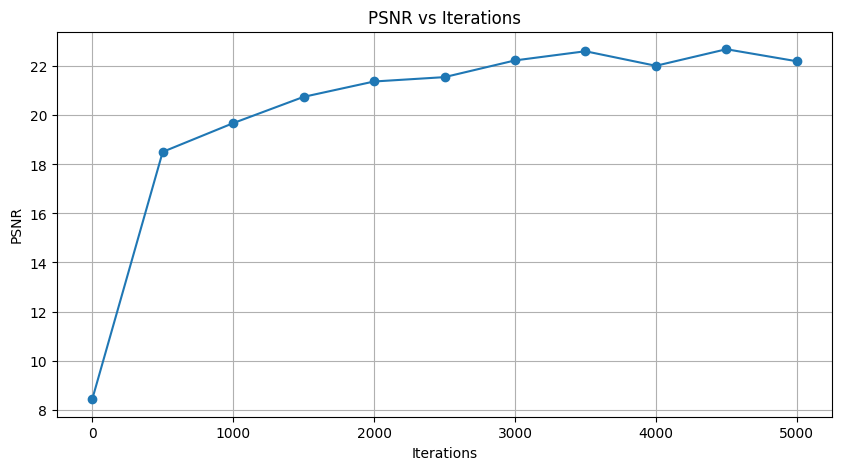

Iteration 5100: Loss 0.004303966648876667, Time per iter: 29.88s, Estimated time remaining: 743988.94s
Iteration 5200: Loss 0.00410888995975256, Time per iter: 16.44s, Estimated time remaining: 407776.02s
Iteration 5300: Loss 0.005253732204437256, Time per iter: 16.45s, Estimated time remaining: 406248.20s
Iteration 5400: Loss 0.0039283037185668945, Time per iter: 16.45s, Estimated time remaining: 404728.00s
Iteration 5500: Loss 0.0035685040056705475, Time per iter: 16.46s, Estimated time remaining: 403181.26s


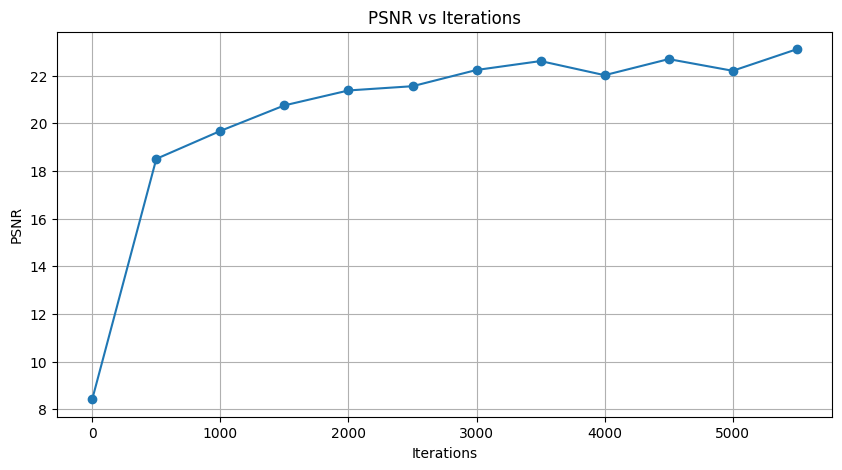

Iteration 5600: Loss 0.001869402825832367, Time per iter: 29.88s, Estimated time remaining: 729112.71s
Iteration 5700: Loss 0.008666414767503738, Time per iter: 16.40s, Estimated time remaining: 398505.91s
Iteration 5800: Loss 0.002845322247594595, Time per iter: 16.40s, Estimated time remaining: 396963.42s
Iteration 5900: Loss 0.004920335486531258, Time per iter: 16.44s, Estimated time remaining: 396204.64s
Iteration 6000: Loss 0.0034396934788674116, Time per iter: 16.46s, Estimated time remaining: 395026.77s


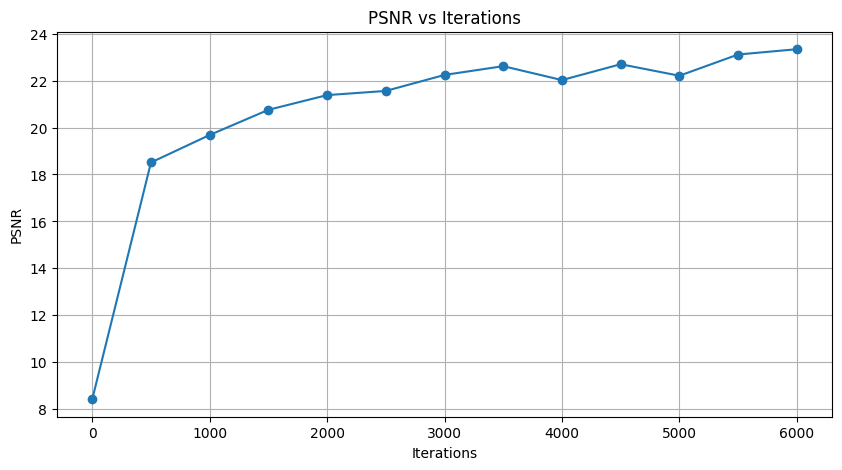

Iteration 6100: Loss 0.005749460309743881, Time per iter: 29.81s, Estimated time remaining: 712529.05s
Iteration 6200: Loss 0.004789333790540695, Time per iter: 16.38s, Estimated time remaining: 389864.48s
Iteration 6300: Loss 0.004742641933262348, Time per iter: 16.41s, Estimated time remaining: 388927.97s
Iteration 6400: Loss 0.001418640254996717, Time per iter: 16.42s, Estimated time remaining: 387527.77s
Iteration 6500: Loss 0.004360389895737171, Time per iter: 16.44s, Estimated time remaining: 386278.85s


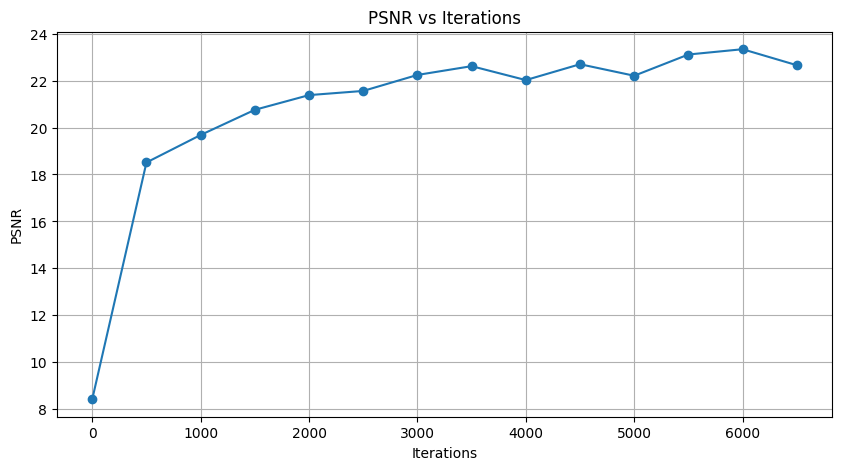

Iteration 6600: Loss 0.006045949645340443, Time per iter: 29.85s, Estimated time remaining: 698394.05s
Iteration 6700: Loss 0.00426552863791585, Time per iter: 16.41s, Estimated time remaining: 382278.86s
Iteration 6800: Loss 0.004200380761176348, Time per iter: 16.38s, Estimated time remaining: 379924.87s
Iteration 6900: Loss 0.004230611026287079, Time per iter: 16.40s, Estimated time remaining: 378769.99s
Iteration 7000: Loss 0.007016757037490606, Time per iter: 16.44s, Estimated time remaining: 378207.93s


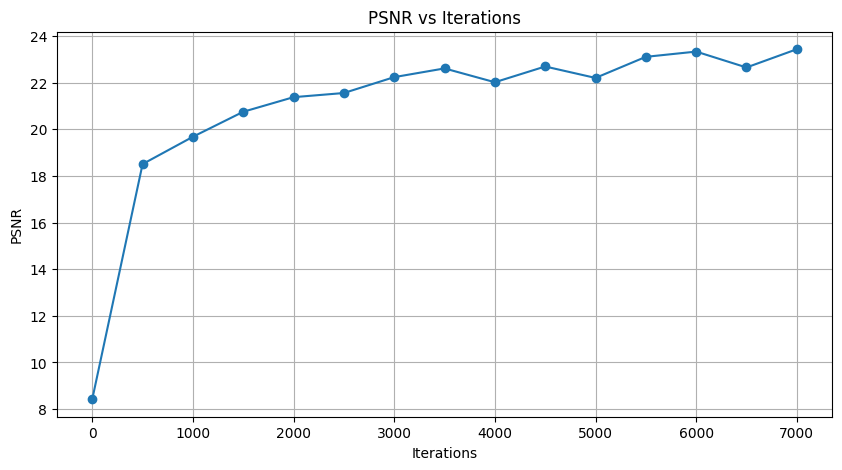

Iteration 7100: Loss 0.0019386452622711658, Time per iter: 29.83s, Estimated time remaining: 683058.29s
Iteration 7200: Loss 0.004808553494513035, Time per iter: 16.39s, Estimated time remaining: 373639.76s
Iteration 7300: Loss 0.002898025792092085, Time per iter: 16.41s, Estimated time remaining: 372443.88s
Iteration 7400: Loss 0.005830385722219944, Time per iter: 16.41s, Estimated time remaining: 370958.15s
Iteration 7500: Loss 0.004409839399158955, Time per iter: 16.41s, Estimated time remaining: 369231.81s


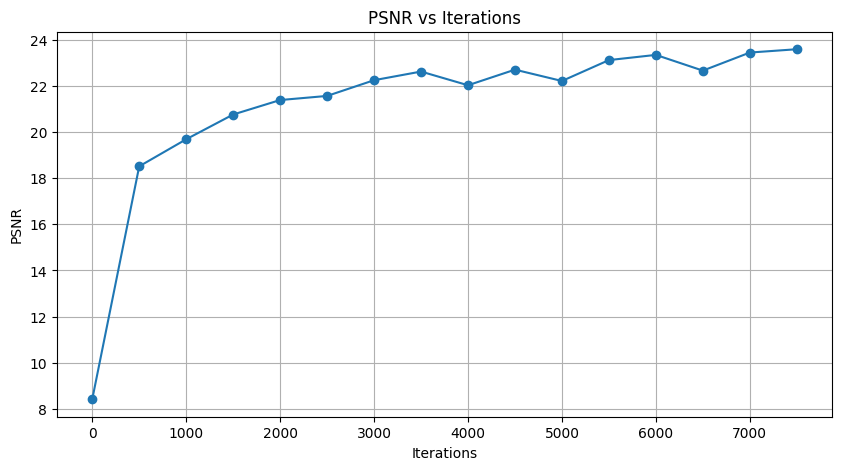

Iteration 7600: Loss 0.0020435266196727753, Time per iter: 29.80s, Estimated time remaining: 667612.29s
Iteration 7700: Loss 0.002332787960767746, Time per iter: 16.40s, Estimated time remaining: 365815.71s
Iteration 7800: Loss 0.004637118428945541, Time per iter: 16.45s, Estimated time remaining: 365088.80s
Iteration 7900: Loss 0.0034086969681084156, Time per iter: 16.63s, Estimated time remaining: 367419.39s
Iteration 8000: Loss 0.00903692003339529, Time per iter: 16.51s, Estimated time remaining: 363284.21s


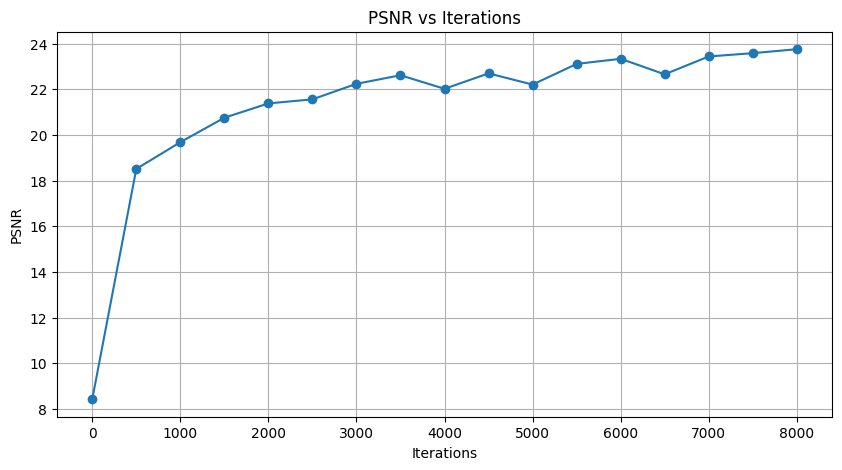

Iteration 8100: Loss 0.002957095392048359, Time per iter: 29.90s, Estimated time remaining: 654825.41s
Iteration 8200: Loss 0.005533162038773298, Time per iter: 16.43s, Estimated time remaining: 358216.83s
Iteration 8300: Loss 0.005536315497010946, Time per iter: 16.44s, Estimated time remaining: 356818.28s
Iteration 8400: Loss 0.004718267358839512, Time per iter: 16.42s, Estimated time remaining: 354639.84s
Iteration 8500: Loss 0.0028337049297988415, Time per iter: 16.43s, Estimated time remaining: 353263.42s


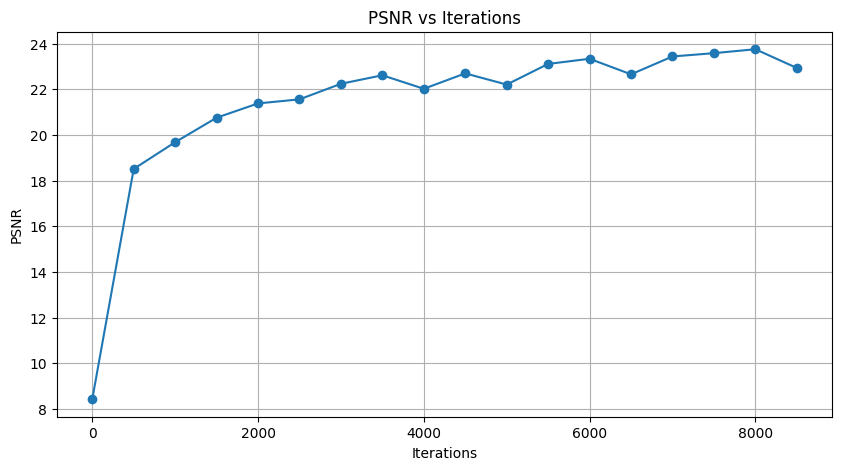

Iteration 8600: Loss 0.0044029755517840385, Time per iter: 29.84s, Estimated time remaining: 638496.08s
Iteration 8700: Loss 0.005791689269244671, Time per iter: 16.37s, Estimated time remaining: 348639.88s
Iteration 8800: Loss 0.0028198244981467724, Time per iter: 16.42s, Estimated time remaining: 348024.49s
Iteration 8900: Loss 0.005506171844899654, Time per iter: 16.41s, Estimated time remaining: 346336.35s
Iteration 9000: Loss 0.004946206696331501, Time per iter: 16.43s, Estimated time remaining: 344967.96s


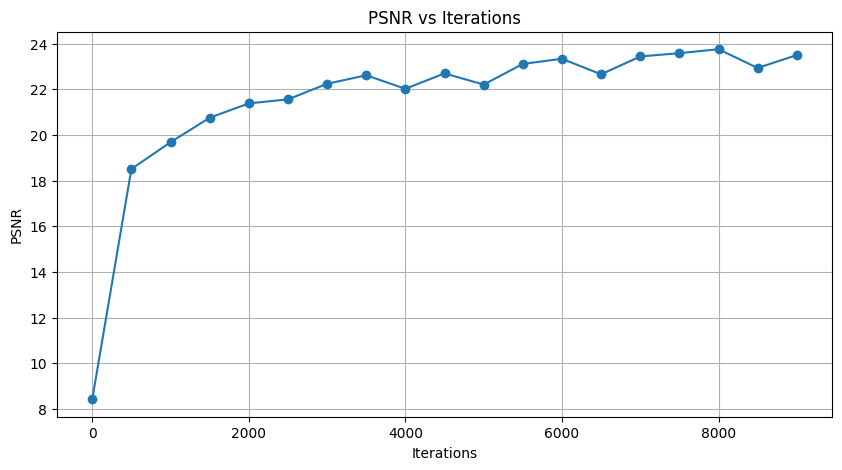

Iteration 9100: Loss 0.005800568964332342, Time per iter: 29.89s, Estimated time remaining: 624789.73s
Iteration 9200: Loss 0.002207323210313916, Time per iter: 16.39s, Estimated time remaining: 340963.36s
Iteration 9300: Loss 0.003554968861863017, Time per iter: 16.42s, Estimated time remaining: 339996.74s
Iteration 9400: Loss 0.003126633120700717, Time per iter: 16.40s, Estimated time remaining: 337939.83s
Iteration 9500: Loss 0.005678217858076096, Time per iter: 16.41s, Estimated time remaining: 336495.83s


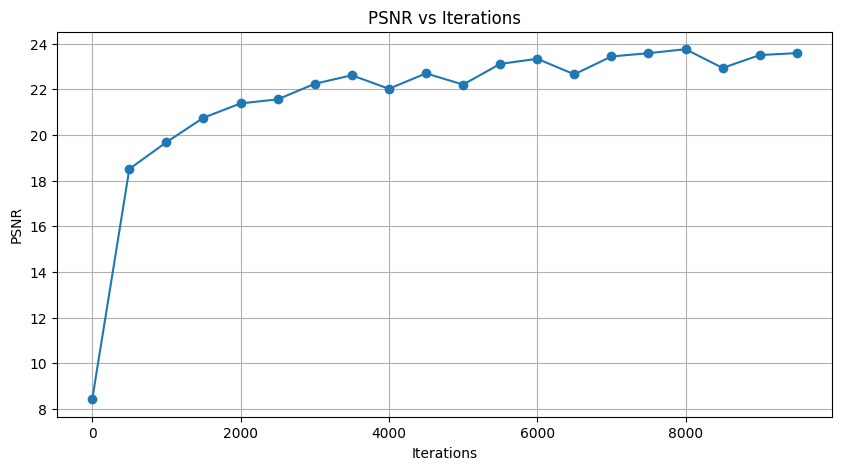

Iteration 9600: Loss 0.004164543934166431, Time per iter: 29.83s, Estimated time remaining: 608605.83s
Iteration 9700: Loss 0.002585684647783637, Time per iter: 16.39s, Estimated time remaining: 332633.12s
Iteration 9800: Loss 0.0024661067873239517, Time per iter: 16.41s, Estimated time remaining: 331389.43s
Iteration 9900: Loss 0.001969614066183567, Time per iter: 16.39s, Estimated time remaining: 329523.67s
Iteration 10000: Loss 0.002323016058653593, Time per iter: 16.41s, Estimated time remaining: 328225.54s


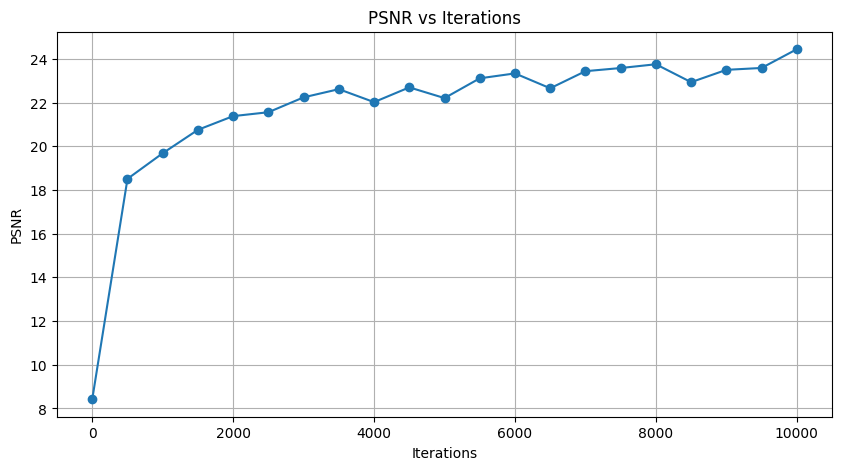

Iteration 10100: Loss 0.0019810409285128117, Time per iter: 29.79s, Estimated time remaining: 592849.95s
Iteration 10200: Loss 0.0027511853259056807, Time per iter: 16.32s, Estimated time remaining: 323206.27s
Iteration 10300: Loss 0.005492843687534332, Time per iter: 16.37s, Estimated time remaining: 322479.02s
Iteration 10400: Loss 0.004238796420395374, Time per iter: 16.37s, Estimated time remaining: 320925.44s
Iteration 10500: Loss 0.00300551182590425, Time per iter: 16.39s, Estimated time remaining: 319548.66s


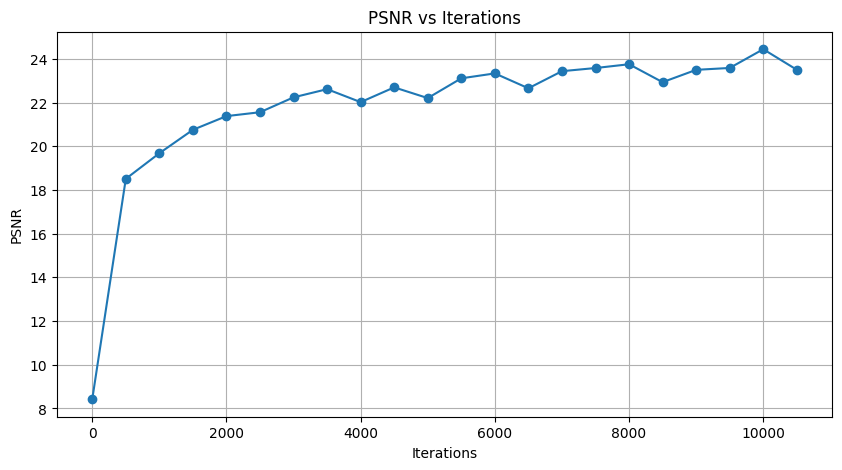

Iteration 10600: Loss 0.004566313233226538, Time per iter: 29.91s, Estimated time remaining: 580328.50s
Iteration 10700: Loss 0.004741676151752472, Time per iter: 16.37s, Estimated time remaining: 315986.78s
Iteration 10800: Loss 0.004454286303371191, Time per iter: 16.40s, Estimated time remaining: 314882.77s
Iteration 10900: Loss 0.004877363331615925, Time per iter: 16.36s, Estimated time remaining: 312460.01s
Iteration 11000: Loss 0.004227752797305584, Time per iter: 16.38s, Estimated time remaining: 311270.36s


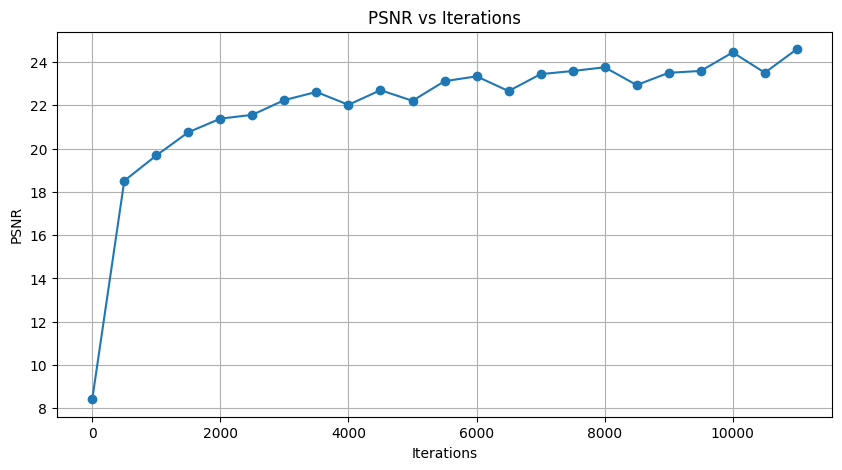

Iteration 11100: Loss 0.004903703927993774, Time per iter: 29.76s, Estimated time remaining: 562415.52s
Iteration 11200: Loss 0.003958407789468765, Time per iter: 16.31s, Estimated time remaining: 306637.40s
Iteration 11300: Loss 0.002858709078282118, Time per iter: 16.32s, Estimated time remaining: 305153.65s
Iteration 11400: Loss 0.004398483317345381, Time per iter: 16.33s, Estimated time remaining: 303760.36s
Iteration 11500: Loss 0.0030591420363634825, Time per iter: 16.34s, Estimated time remaining: 302276.73s


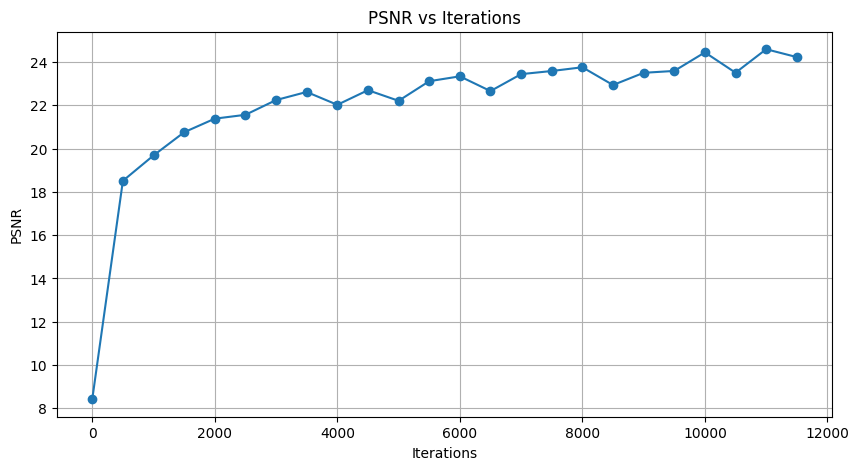

Iteration 11600: Loss 0.0020414183381944895, Time per iter: 29.81s, Estimated time remaining: 548568.53s
Iteration 11700: Loss 0.0040528010576963425, Time per iter: 16.32s, Estimated time remaining: 298666.41s
Iteration 11800: Loss 0.0024634646251797676, Time per iter: 16.33s, Estimated time remaining: 297218.48s
Iteration 11900: Loss 0.003859987948089838, Time per iter: 16.38s, Estimated time remaining: 296387.60s
Iteration 12000: Loss 0.004917360842227936, Time per iter: 16.39s, Estimated time remaining: 295082.86s


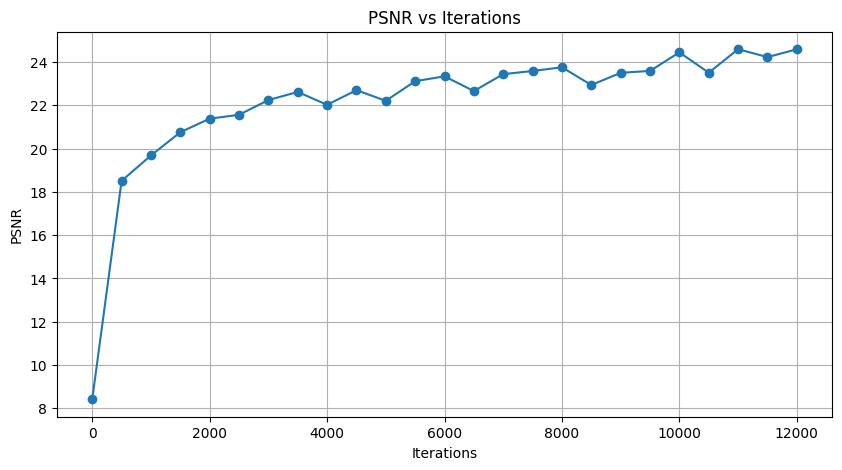

Iteration 12100: Loss 0.002573452889919281, Time per iter: 29.76s, Estimated time remaining: 532725.23s
Iteration 12200: Loss 0.0032302956096827984, Time per iter: 16.32s, Estimated time remaining: 290570.35s
Iteration 12300: Loss 0.0036410782486200333, Time per iter: 16.34s, Estimated time remaining: 289283.58s
Iteration 12400: Loss 0.0038270759396255016, Time per iter: 16.35s, Estimated time remaining: 287740.84s
Iteration 12500: Loss 0.005424510687589645, Time per iter: 16.38s, Estimated time remaining: 286627.83s


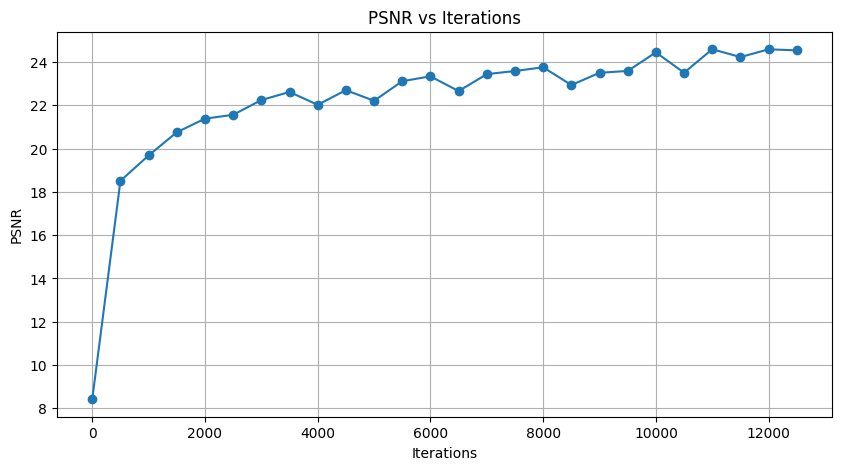

Iteration 12600: Loss 0.003234466537833214, Time per iter: 29.74s, Estimated time remaining: 517478.64s
Iteration 12700: Loss 0.0026682657189667225, Time per iter: 16.35s, Estimated time remaining: 282882.36s
Iteration 12800: Loss 0.0017012038733810186, Time per iter: 16.33s, Estimated time remaining: 280851.30s
Iteration 12900: Loss 0.004038669168949127, Time per iter: 16.35s, Estimated time remaining: 279537.78s
Iteration 13000: Loss 0.0022645369172096252, Time per iter: 16.37s, Estimated time remaining: 278351.59s


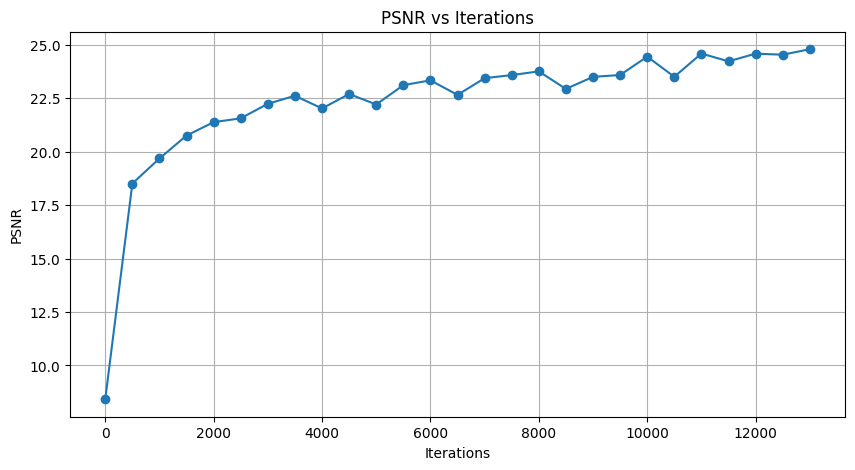

Iteration 13100: Loss 0.0026562060229480267, Time per iter: 29.72s, Estimated time remaining: 502268.49s
Iteration 13200: Loss 0.0023510707542300224, Time per iter: 16.30s, Estimated time remaining: 273758.45s
Iteration 13300: Loss 0.003426247974857688, Time per iter: 16.32s, Estimated time remaining: 272461.55s
Iteration 13400: Loss 0.0022083469666540623, Time per iter: 16.36s, Estimated time remaining: 271493.76s
Iteration 13500: Loss 0.004634504206478596, Time per iter: 16.38s, Estimated time remaining: 270287.87s


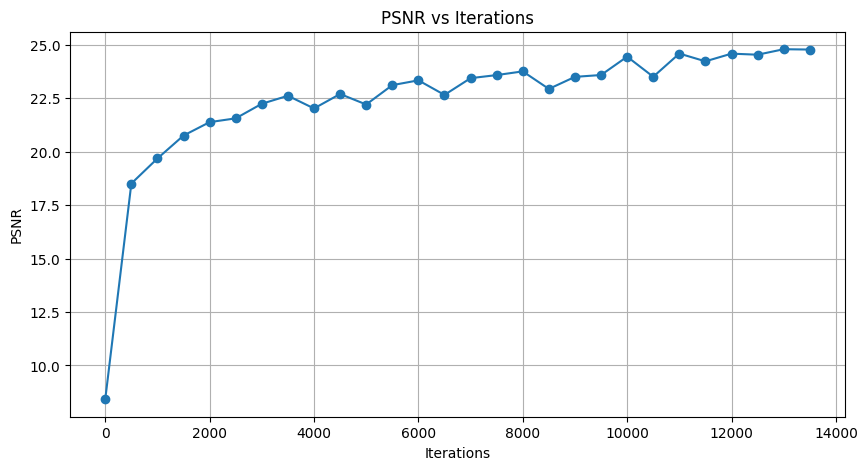

Iteration 13600: Loss 0.0021462428849190474, Time per iter: 30.10s, Estimated time remaining: 493588.17s
Iteration 13700: Loss 0.004105047322809696, Time per iter: 16.46s, Estimated time remaining: 268336.08s
Iteration 13800: Loss 0.0029685392510145903, Time per iter: 16.40s, Estimated time remaining: 265661.06s
Iteration 13900: Loss 0.00480632483959198, Time per iter: 16.40s, Estimated time remaining: 264077.66s
Iteration 14000: Loss 0.0027131838724017143, Time per iter: 16.39s, Estimated time remaining: 262238.32s


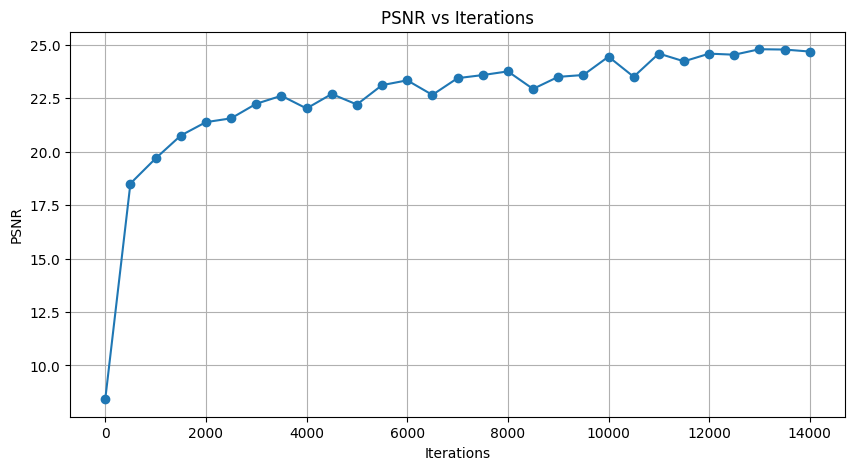

Iteration 14100: Loss 0.001468069851398468, Time per iter: 29.78s, Estimated time remaining: 473576.18s
Iteration 14200: Loss 0.0033598465379327536, Time per iter: 16.34s, Estimated time remaining: 258189.08s
Iteration 14300: Loss 0.002429880201816559, Time per iter: 16.34s, Estimated time remaining: 256587.59s
Iteration 14400: Loss 0.0021447015460580587, Time per iter: 16.36s, Estimated time remaining: 255153.35s
Iteration 14500: Loss 0.0027958699502050877, Time per iter: 16.42s, Estimated time remaining: 254489.14s


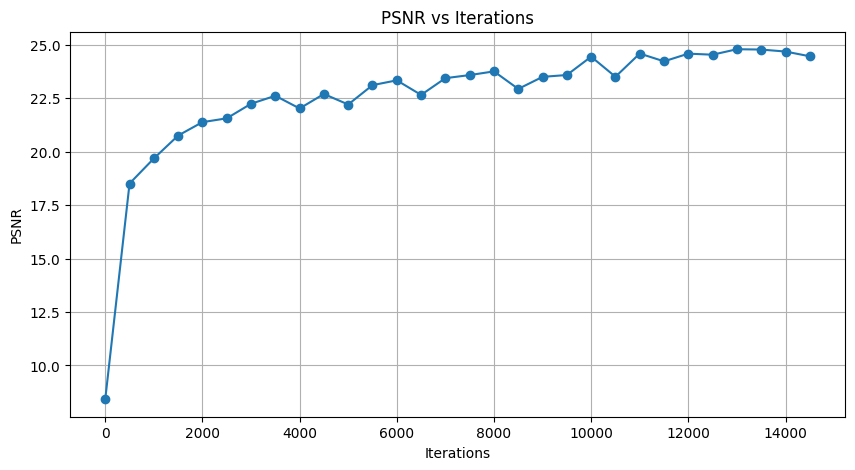

Iteration 14600: Loss 0.002304935362190008, Time per iter: 29.94s, Estimated time remaining: 461088.46s
Iteration 14700: Loss 0.0026966482400894165, Time per iter: 16.33s, Estimated time remaining: 249918.00s
Iteration 14800: Loss 0.0027263974770903587, Time per iter: 16.35s, Estimated time remaining: 248453.12s
Iteration 14900: Loss 0.0014351167483255267, Time per iter: 16.37s, Estimated time remaining: 247241.26s
Iteration 15000: Loss 0.0033416864462196827, Time per iter: 16.35s, Estimated time remaining: 245295.13s


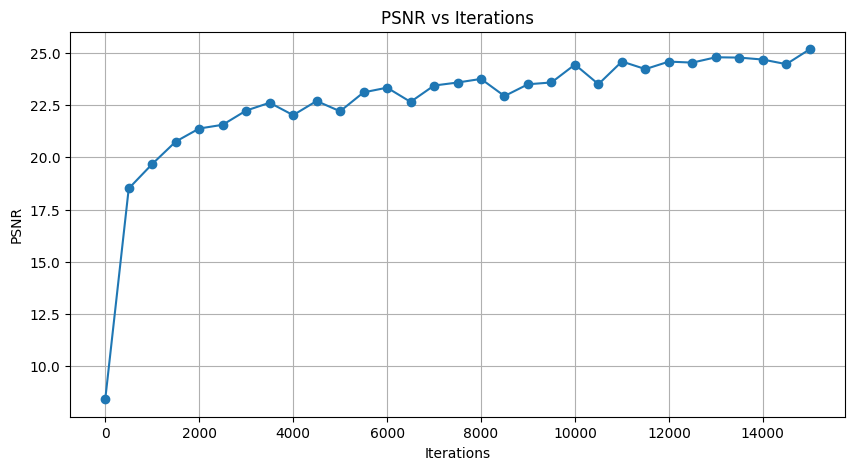

Iteration 15100: Loss 0.0032018839847296476, Time per iter: 29.76s, Estimated time remaining: 443393.22s
Iteration 15200: Loss 0.0015688057756051421, Time per iter: 16.30s, Estimated time remaining: 241261.51s
Iteration 15300: Loss 0.0020572752691805363, Time per iter: 16.32s, Estimated time remaining: 239953.27s
Iteration 15400: Loss 0.0033856499940156937, Time per iter: 16.32s, Estimated time remaining: 238281.74s
Iteration 15500: Loss 0.00357429264113307, Time per iter: 16.32s, Estimated time remaining: 236683.56s


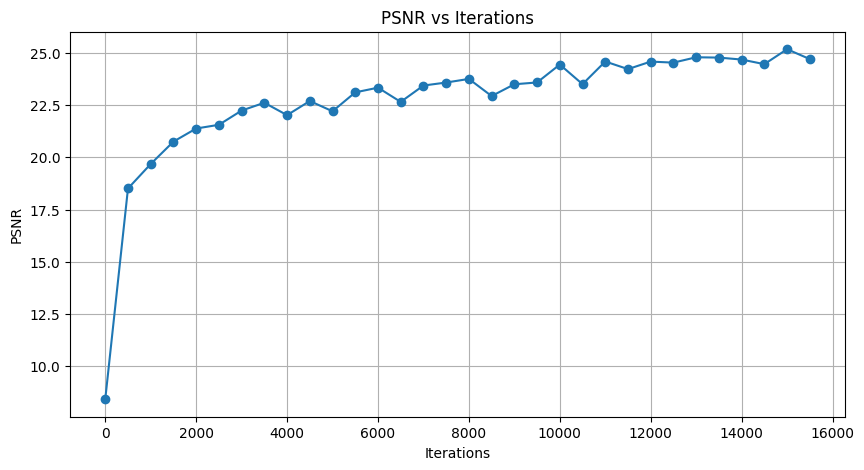

Iteration 15600: Loss 0.00191520806401968, Time per iter: 29.72s, Estimated time remaining: 427964.62s
Iteration 15700: Loss 0.0018393512582406402, Time per iter: 16.33s, Estimated time remaining: 233477.76s
Iteration 15800: Loss 0.0031412045937031507, Time per iter: 16.34s, Estimated time remaining: 232066.82s
Iteration 15900: Loss 0.0014745885273441672, Time per iter: 16.34s, Estimated time remaining: 230440.80s
Iteration 16000: Loss 0.0015781869878992438, Time per iter: 16.34s, Estimated time remaining: 228787.08s


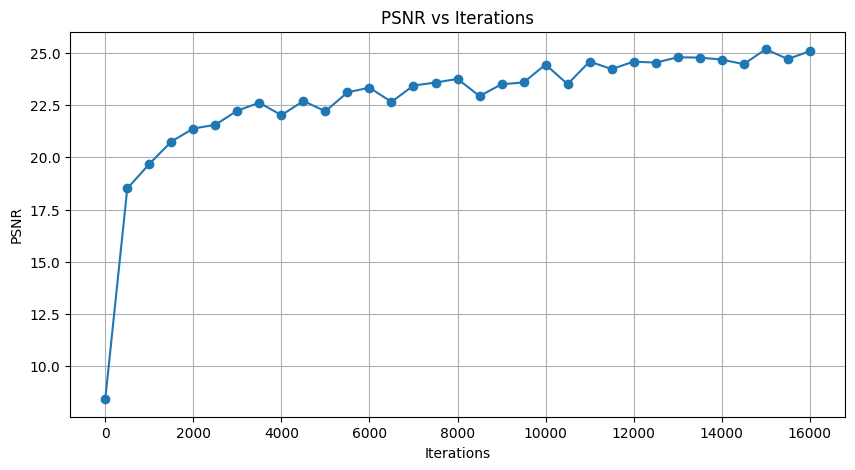

Iteration 16100: Loss 0.004623831249773502, Time per iter: 29.73s, Estimated time remaining: 413233.55s
Iteration 16200: Loss 0.0030276067554950714, Time per iter: 16.27s, Estimated time remaining: 224477.62s
Iteration 16300: Loss 0.0017890192102640867, Time per iter: 16.29s, Estimated time remaining: 223180.81s
Iteration 16400: Loss 0.004301467444747686, Time per iter: 16.30s, Estimated time remaining: 221701.48s
Iteration 16500: Loss 0.004309487994760275, Time per iter: 16.33s, Estimated time remaining: 220437.08s


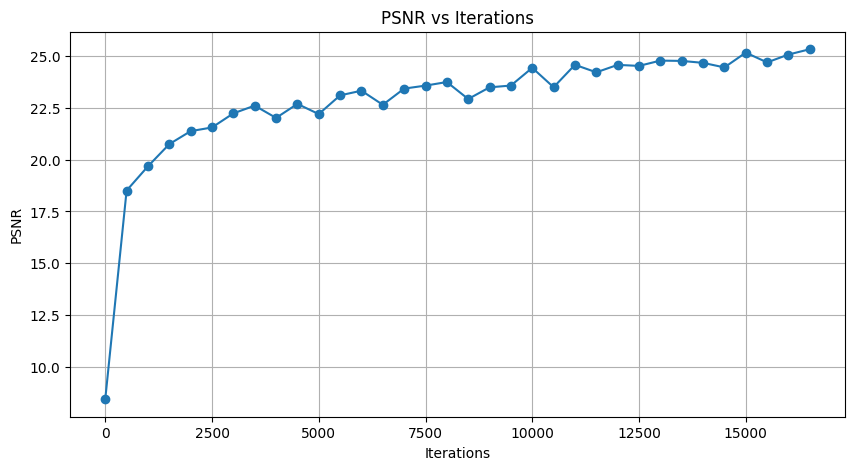

Iteration 16600: Loss 0.003484114771708846, Time per iter: 29.72s, Estimated time remaining: 398273.53s
Iteration 16700: Loss 0.0024932511150836945, Time per iter: 16.31s, Estimated time remaining: 216907.23s
Iteration 16800: Loss 0.004353474825620651, Time per iter: 16.31s, Estimated time remaining: 215292.62s
Iteration 16900: Loss 0.002906107110902667, Time per iter: 16.32s, Estimated time remaining: 213835.47s
Iteration 17000: Loss 0.004116002935916185, Time per iter: 16.33s, Estimated time remaining: 212230.75s


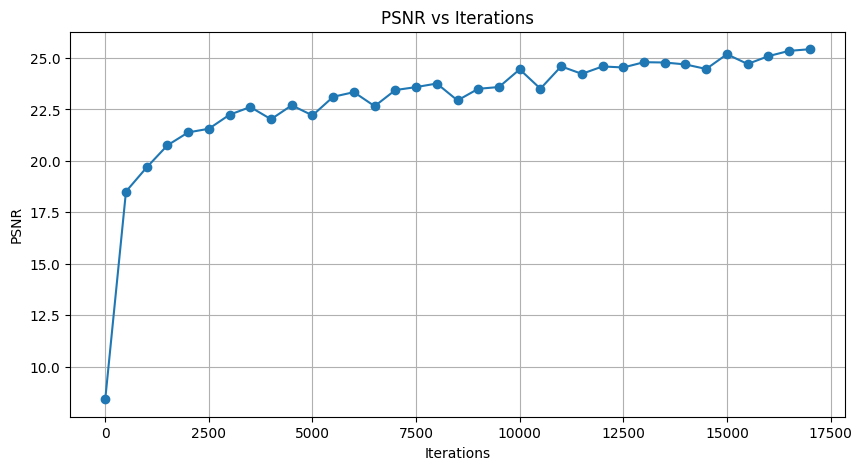

Iteration 17100: Loss 0.0017262747278437018, Time per iter: 29.72s, Estimated time remaining: 383450.90s
Iteration 17200: Loss 0.004957245662808418, Time per iter: 16.31s, Estimated time remaining: 208791.72s
Iteration 17300: Loss 0.0020091484766453505, Time per iter: 16.31s, Estimated time remaining: 207191.65s
Iteration 17400: Loss 0.0037333406507968903, Time per iter: 16.31s, Estimated time remaining: 205552.39s
Iteration 17500: Loss 0.001758999191224575, Time per iter: 16.32s, Estimated time remaining: 204044.07s


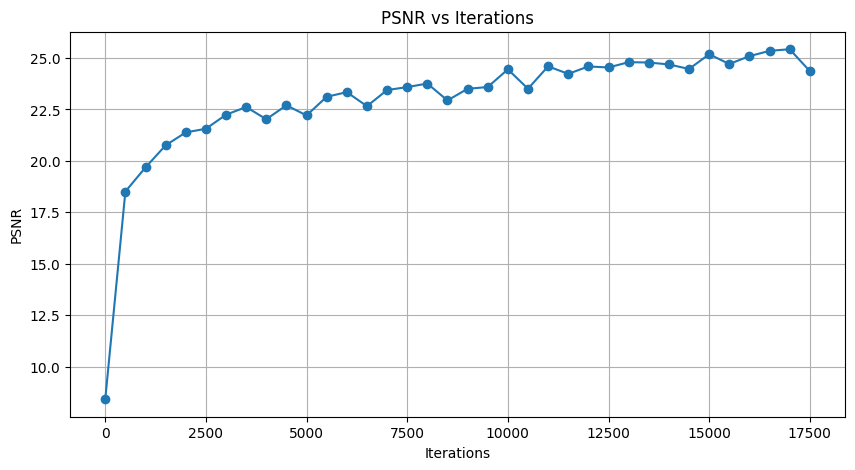

Iteration 17600: Loss 0.0015360880643129349, Time per iter: 29.78s, Estimated time remaining: 369242.78s
Iteration 17700: Loss 0.0021193325519561768, Time per iter: 16.30s, Estimated time remaining: 200542.38s
Iteration 17800: Loss 0.0034373390953987837, Time per iter: 16.34s, Estimated time remaining: 199312.11s
Iteration 17900: Loss 0.0026487212162464857, Time per iter: 16.33s, Estimated time remaining: 197582.73s
Iteration 18000: Loss 0.002867573406547308, Time per iter: 16.35s, Estimated time remaining: 196205.61s


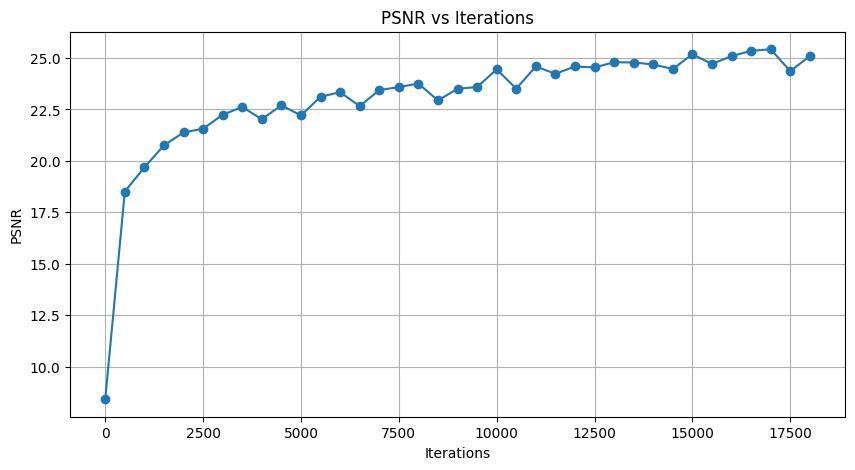

Iteration 18100: Loss 0.0007519113714806736, Time per iter: 29.74s, Estimated time remaining: 353906.91s
Iteration 18200: Loss 0.0018799267709255219, Time per iter: 16.31s, Estimated time remaining: 192430.78s
Iteration 18300: Loss 0.0031305409502238035, Time per iter: 16.32s, Estimated time remaining: 190968.69s
Iteration 18400: Loss 0.0029042591340839863, Time per iter: 16.33s, Estimated time remaining: 189407.64s
Iteration 18500: Loss 0.0037222853861749172, Time per iter: 16.31s, Estimated time remaining: 187531.57s


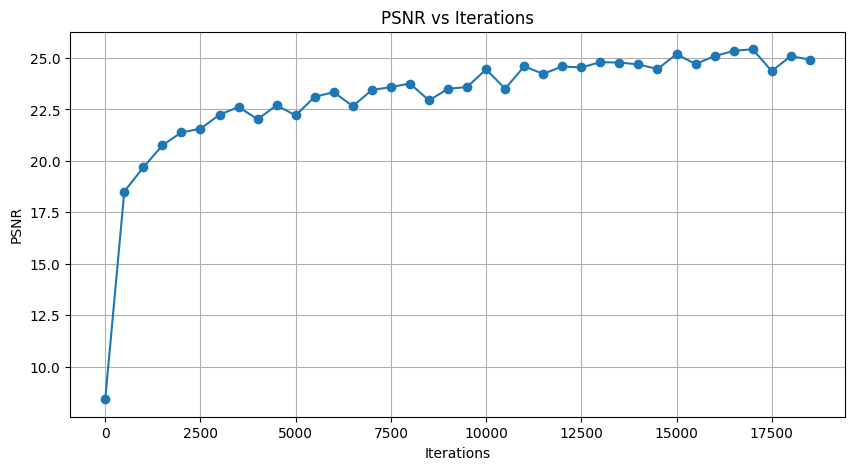

Iteration 18600: Loss 0.0022577401250600815, Time per iter: 29.74s, Estimated time remaining: 339040.20s
Iteration 18700: Loss 0.004031406249850988, Time per iter: 16.32s, Estimated time remaining: 184399.46s
Iteration 18800: Loss 0.0025247479788959026, Time per iter: 16.35s, Estimated time remaining: 183123.48s
Iteration 18900: Loss 0.0022125663235783577, Time per iter: 16.35s, Estimated time remaining: 181467.02s
Iteration 19000: Loss 0.0013561835512518883, Time per iter: 16.36s, Estimated time remaining: 179985.11s


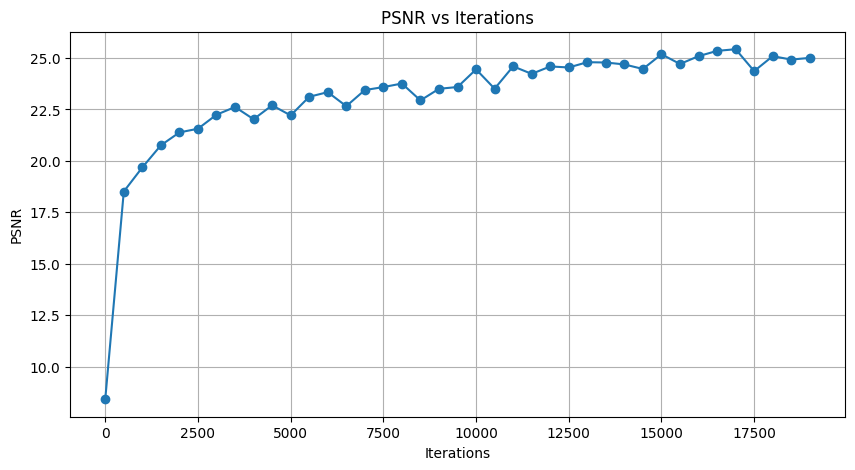

Iteration 19100: Loss 0.0032090316526591778, Time per iter: 29.78s, Estimated time remaining: 324589.95s
Iteration 19200: Loss 0.0015776071231812239, Time per iter: 16.35s, Estimated time remaining: 176532.05s
Iteration 19300: Loss 0.0019516665488481522, Time per iter: 16.32s, Estimated time remaining: 174603.30s
Iteration 19400: Loss 0.0043650055304169655, Time per iter: 16.31s, Estimated time remaining: 172854.14s
Iteration 19500: Loss 0.0037979185581207275, Time per iter: 16.34s, Estimated time remaining: 171518.51s


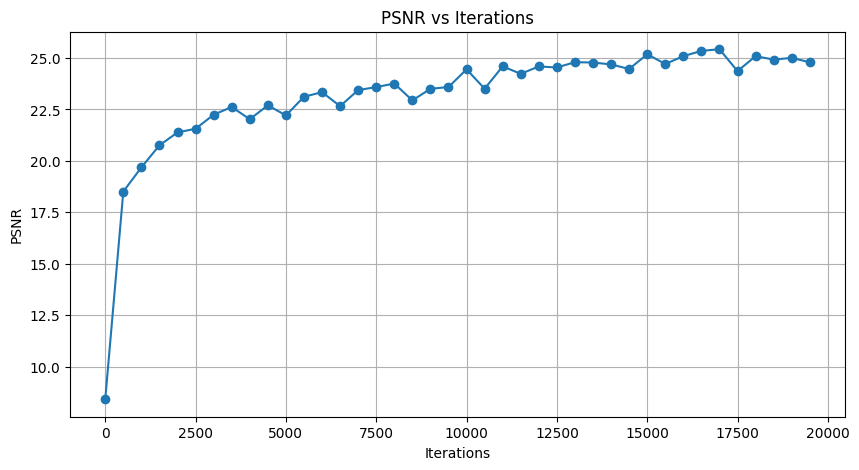

Iteration 19600: Loss 0.003854836104437709, Time per iter: 29.73s, Estimated time remaining: 309222.86s
Iteration 19700: Loss 0.001273609697818756, Time per iter: 16.30s, Estimated time remaining: 167881.79s
Iteration 19800: Loss 0.0016391982790082693, Time per iter: 16.33s, Estimated time remaining: 166597.60s
Iteration 19900: Loss 0.00221020495519042, Time per iter: 16.36s, Estimated time remaining: 165212.04s
Iteration 20000: Loss 0.002675859723240137, Time per iter: 16.36s, Estimated time remaining: 163648.64s


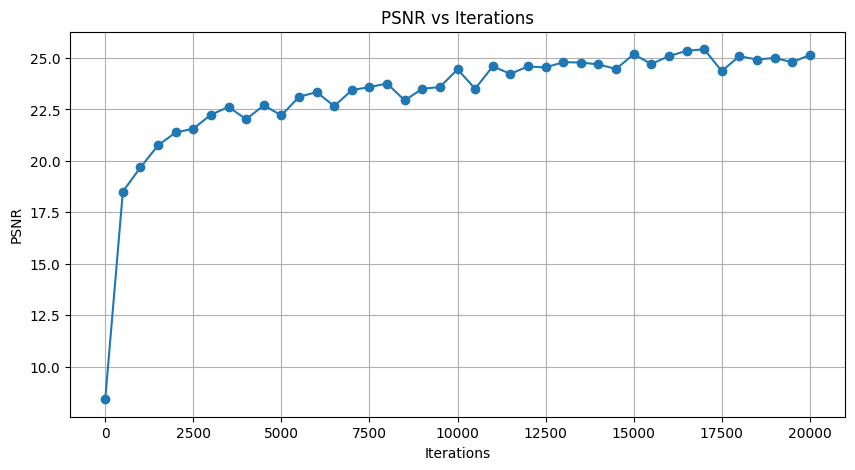

Iteration 20100: Loss 0.0019377082353457808, Time per iter: 29.82s, Estimated time remaining: 295172.31s
Iteration 20200: Loss 0.004172691144049168, Time per iter: 16.32s, Estimated time remaining: 159965.84s
Iteration 20300: Loss 0.0022330896463245153, Time per iter: 16.31s, Estimated time remaining: 158192.21s
Iteration 20400: Loss 0.0029447353444993496, Time per iter: 16.33s, Estimated time remaining: 156763.10s
Iteration 20500: Loss 0.0026961131952703, Time per iter: 16.34s, Estimated time remaining: 155274.52s


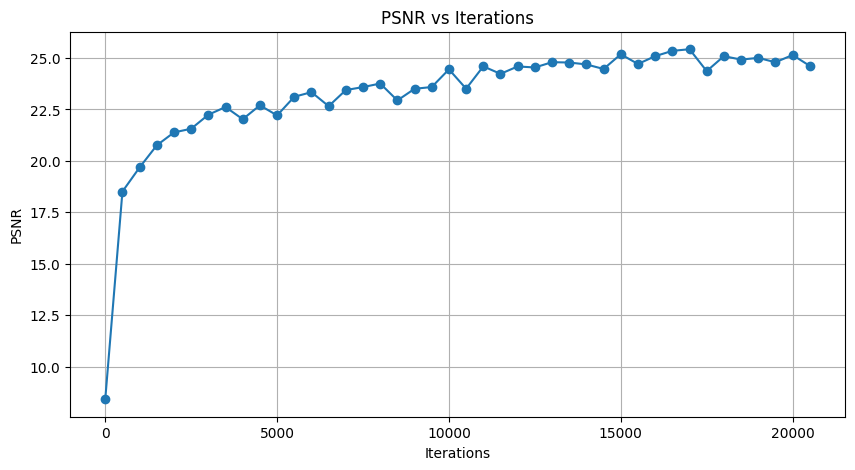

Iteration 20600: Loss 0.003926197998225689, Time per iter: 29.74s, Estimated time remaining: 279514.48s
Iteration 20700: Loss 0.002977171679958701, Time per iter: 16.29s, Estimated time remaining: 151538.66s
Iteration 20800: Loss 0.001992476172745228, Time per iter: 16.31s, Estimated time remaining: 150094.08s
Iteration 20900: Loss 0.0018402829300612211, Time per iter: 16.31s, Estimated time remaining: 148391.88s
Iteration 21000: Loss 0.0023360613267868757, Time per iter: 16.35s, Estimated time remaining: 147127.17s


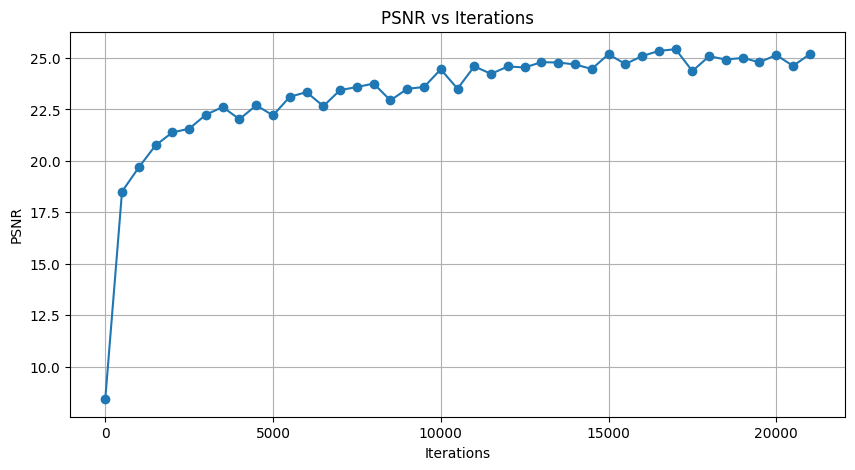

Iteration 21100: Loss 0.00395157840102911, Time per iter: 29.70s, Estimated time remaining: 264348.03s
Iteration 21200: Loss 0.004001257009804249, Time per iter: 16.30s, Estimated time remaining: 143404.21s
Iteration 21300: Loss 0.002267897827550769, Time per iter: 16.32s, Estimated time remaining: 141964.62s
Iteration 21400: Loss 0.003029113169759512, Time per iter: 16.32s, Estimated time remaining: 140312.24s
Iteration 21500: Loss 0.002249518409371376, Time per iter: 16.34s, Estimated time remaining: 138909.28s


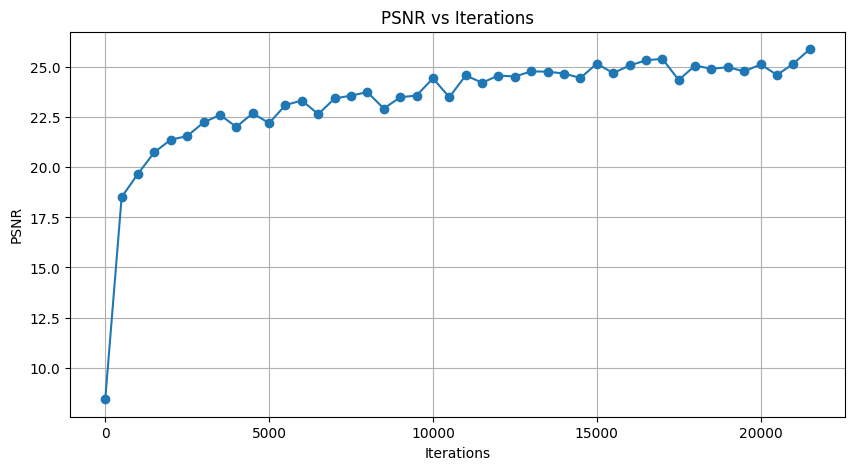

Iteration 21600: Loss 0.002048925729468465, Time per iter: 29.72s, Estimated time remaining: 249623.52s
Iteration 21700: Loss 0.0012899574358016253, Time per iter: 16.30s, Estimated time remaining: 135259.83s
Iteration 21800: Loss 0.0017105777515098453, Time per iter: 16.28s, Estimated time remaining: 133467.78s
Iteration 21900: Loss 0.005123401526361704, Time per iter: 16.31s, Estimated time remaining: 132112.49s
Iteration 22000: Loss 0.002165835117921233, Time per iter: 16.33s, Estimated time remaining: 130644.52s


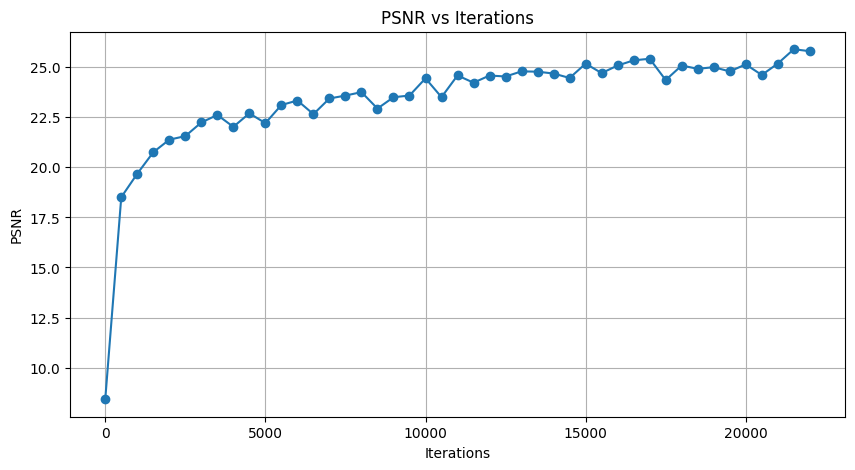

Iteration 22100: Loss 0.001399428816512227, Time per iter: 29.75s, Estimated time remaining: 235015.16s
Iteration 22200: Loss 0.0022865422070026398, Time per iter: 16.28s, Estimated time remaining: 126987.72s
Iteration 22300: Loss 0.0042822714895009995, Time per iter: 16.30s, Estimated time remaining: 125522.85s
Iteration 22400: Loss 0.004057541489601135, Time per iter: 16.33s, Estimated time remaining: 124107.02s
Iteration 22500: Loss 0.0027429424226284027, Time per iter: 16.34s, Estimated time remaining: 122523.77s


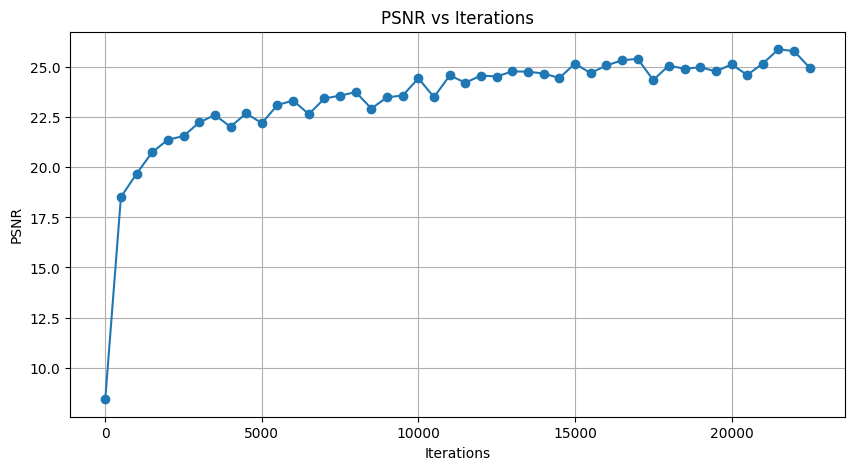

Iteration 22600: Loss 0.0030804842244833708, Time per iter: 29.69s, Estimated time remaining: 219732.17s
Iteration 22700: Loss 0.00418317224830389, Time per iter: 16.28s, Estimated time remaining: 118872.04s
Iteration 22800: Loss 0.002780882641673088, Time per iter: 16.31s, Estimated time remaining: 117420.92s
Iteration 22900: Loss 0.0020472644828259945, Time per iter: 16.32s, Estimated time remaining: 115881.57s
Iteration 23000: Loss 0.0032060290686786175, Time per iter: 16.31s, Estimated time remaining: 114163.49s


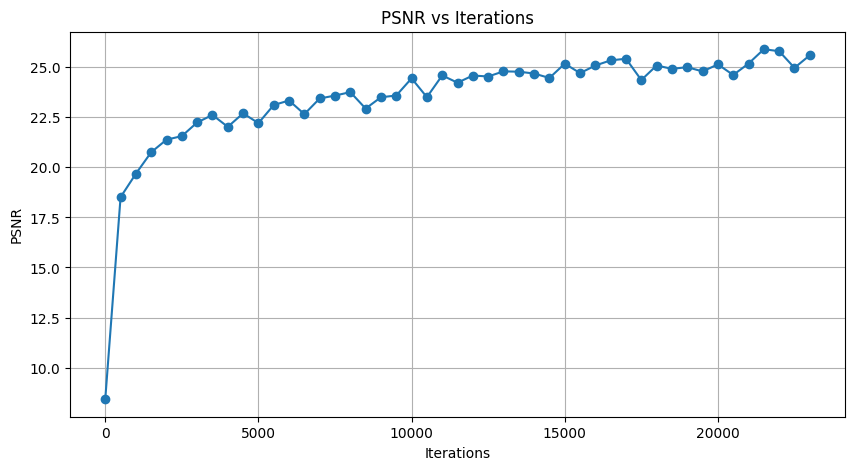

Iteration 23100: Loss 0.0022828637156635523, Time per iter: 29.76s, Estimated time remaining: 205367.47s
Iteration 23200: Loss 0.002416308969259262, Time per iter: 16.30s, Estimated time remaining: 110854.12s
Iteration 23300: Loss 0.002184438519179821, Time per iter: 16.31s, Estimated time remaining: 109308.36s
Iteration 23400: Loss 0.0015224743401631713, Time per iter: 16.34s, Estimated time remaining: 107837.68s
Iteration 23500: Loss 0.0011336627649143338, Time per iter: 16.34s, Estimated time remaining: 106188.56s


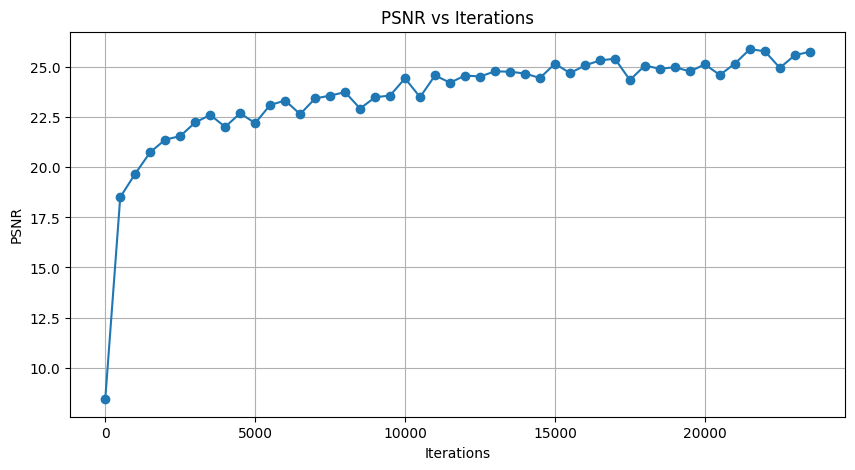

Iteration 23600: Loss 0.002754480578005314, Time per iter: 31.57s, Estimated time remaining: 202024.42s
Iteration 23700: Loss 0.002546049188822508, Time per iter: 17.00s, Estimated time remaining: 107093.88s
Iteration 23800: Loss 0.0021306429989635944, Time per iter: 16.96s, Estimated time remaining: 105150.93s
Iteration 23900: Loss 0.0013095596805214882, Time per iter: 16.53s, Estimated time remaining: 100820.71s
Iteration 24000: Loss 0.0035801567137241364, Time per iter: 16.56s, Estimated time remaining: 99349.42s


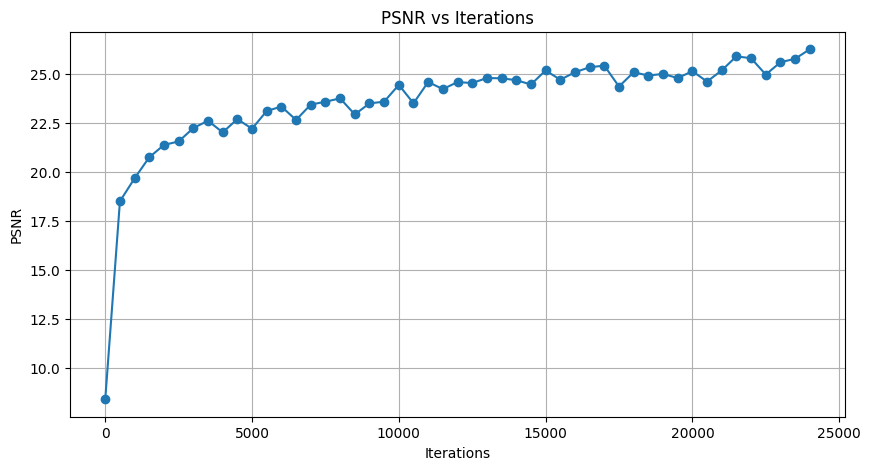

Iteration 24100: Loss 0.004313136450946331, Time per iter: 34.90s, Estimated time remaining: 205882.63s
Iteration 24200: Loss 0.002916445955634117, Time per iter: 16.57s, Estimated time remaining: 96126.59s
Iteration 24300: Loss 0.002412848873063922, Time per iter: 16.55s, Estimated time remaining: 94339.69s
Iteration 24400: Loss 0.003239637240767479, Time per iter: 16.56s, Estimated time remaining: 92759.31s
Iteration 24500: Loss 0.0014160916907712817, Time per iter: 16.59s, Estimated time remaining: 91246.41s


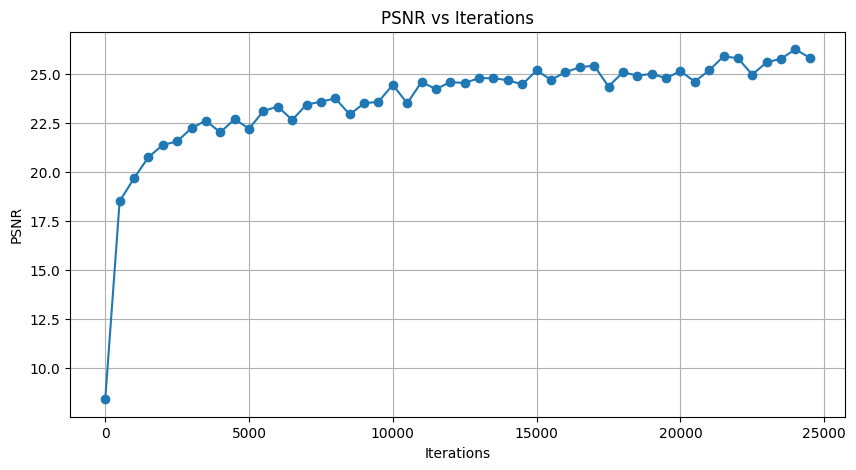

Iteration 24600: Loss 0.0028502177447080612, Time per iter: 30.42s, Estimated time remaining: 164265.83s
Iteration 24700: Loss 0.003946005832403898, Time per iter: 16.80s, Estimated time remaining: 89057.68s
Iteration 24800: Loss 0.004255536012351513, Time per iter: 17.53s, Estimated time remaining: 91166.65s
Iteration 24900: Loss 0.001841093646362424, Time per iter: 14.66s, Estimated time remaining: 74791.17s
Iteration 25000: Loss 0.0026895354967564344, Time per iter: 14.58s, Estimated time remaining: 72889.49s


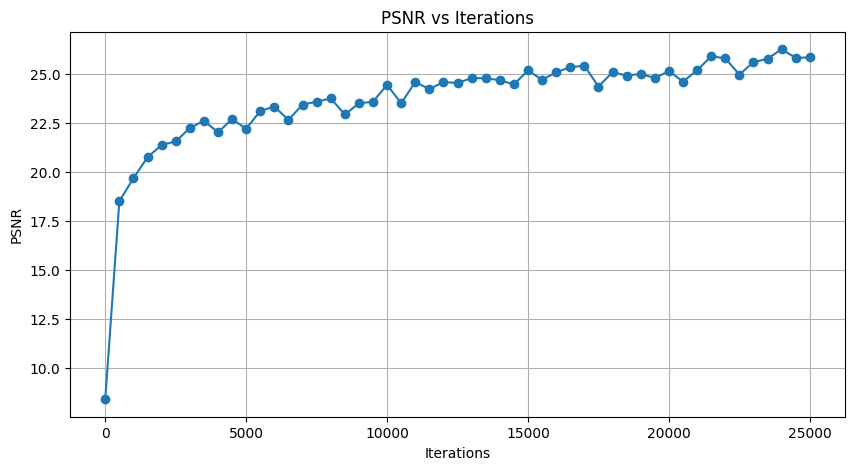

Iteration 25100: Loss 0.0029167570173740387, Time per iter: 29.09s, Estimated time remaining: 142555.82s
Iteration 25200: Loss 0.0022581692319363356, Time per iter: 14.55s, Estimated time remaining: 69827.52s
Iteration 25300: Loss 0.003262218786403537, Time per iter: 14.46s, Estimated time remaining: 67959.13s
Iteration 25400: Loss 0.0032167236786335707, Time per iter: 14.54s, Estimated time remaining: 66863.09s
Iteration 25500: Loss 0.0012965732021257281, Time per iter: 14.53s, Estimated time remaining: 65405.33s


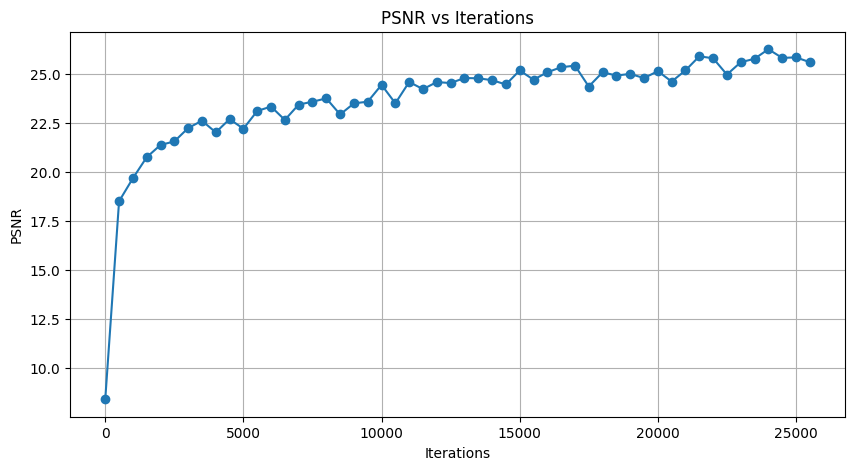

Iteration 25600: Loss 0.001689879223704338, Time per iter: 29.76s, Estimated time remaining: 130924.30s
Iteration 25700: Loss 0.0028818477876484394, Time per iter: 16.16s, Estimated time remaining: 69503.29s
Iteration 25800: Loss 0.001788634224794805, Time per iter: 14.67s, Estimated time remaining: 61633.73s
Iteration 25900: Loss 0.002548046875745058, Time per iter: 14.55s, Estimated time remaining: 59639.22s
Iteration 26000: Loss 0.0017956987721845508, Time per iter: 15.60s, Estimated time remaining: 62391.14s


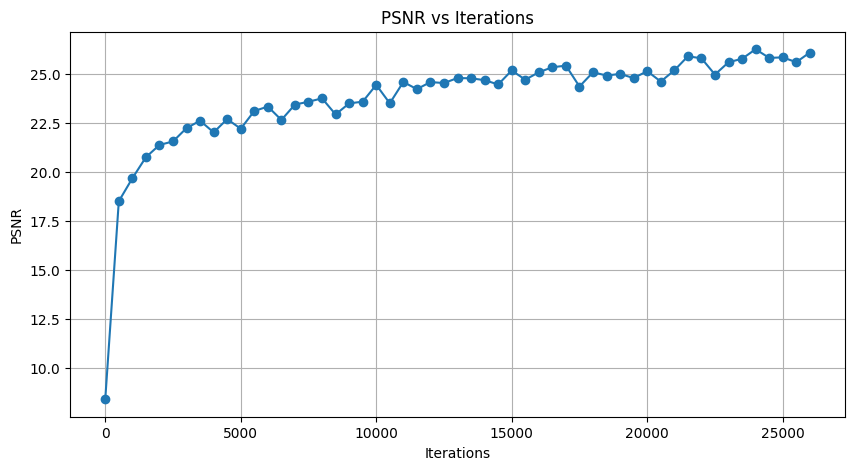

Iteration 26100: Loss 0.0031639847438782454, Time per iter: 32.83s, Estimated time remaining: 128021.86s
Iteration 26200: Loss 0.002865960355848074, Time per iter: 14.89s, Estimated time remaining: 56598.01s
Iteration 26300: Loss 0.00205810833722353, Time per iter: 14.60s, Estimated time remaining: 54018.32s
Iteration 26400: Loss 0.004426354542374611, Time per iter: 14.52s, Estimated time remaining: 52277.89s
Iteration 26500: Loss 0.002824608003720641, Time per iter: 14.82s, Estimated time remaining: 51863.30s


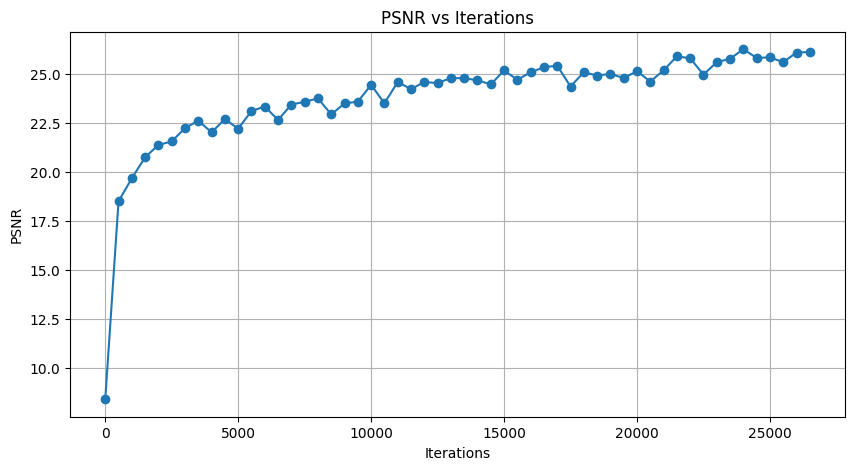

Iteration 26600: Loss 0.004203590098768473, Time per iter: 30.80s, Estimated time remaining: 104704.81s
Iteration 26700: Loss 0.0023870121221989393, Time per iter: 14.32s, Estimated time remaining: 47242.98s
Iteration 26800: Loss 0.0022554006427526474, Time per iter: 14.90s, Estimated time remaining: 47667.72s
Iteration 26900: Loss 0.00208021467551589, Time per iter: 14.40s, Estimated time remaining: 44645.30s
Iteration 27000: Loss 0.0026350412517786026, Time per iter: 14.38s, Estimated time remaining: 43133.67s


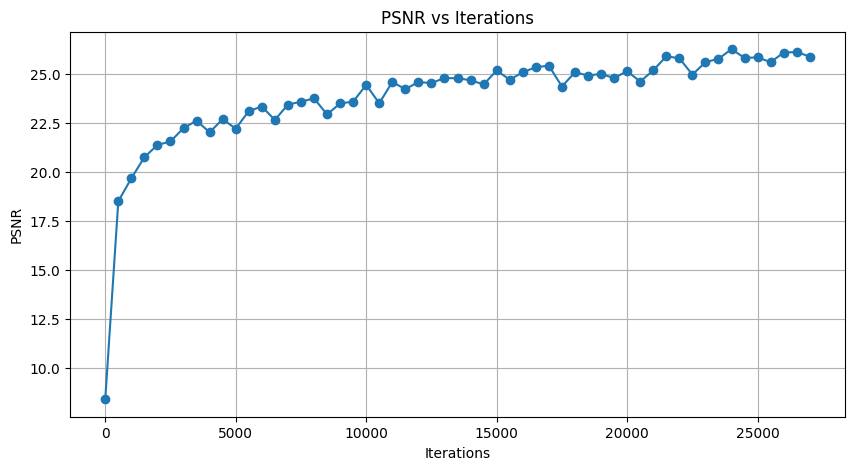

Iteration 27100: Loss 0.002888650167733431, Time per iter: 34.74s, Estimated time remaining: 100732.14s
Iteration 27200: Loss 0.001445462927222252, Time per iter: 14.28s, Estimated time remaining: 39976.11s
Iteration 27300: Loss 0.0010871926788240671, Time per iter: 14.27s, Estimated time remaining: 38519.77s
Iteration 27400: Loss 0.0009387136669829488, Time per iter: 14.30s, Estimated time remaining: 37177.92s
Iteration 27500: Loss 0.00159359909594059, Time per iter: 14.28s, Estimated time remaining: 35704.80s


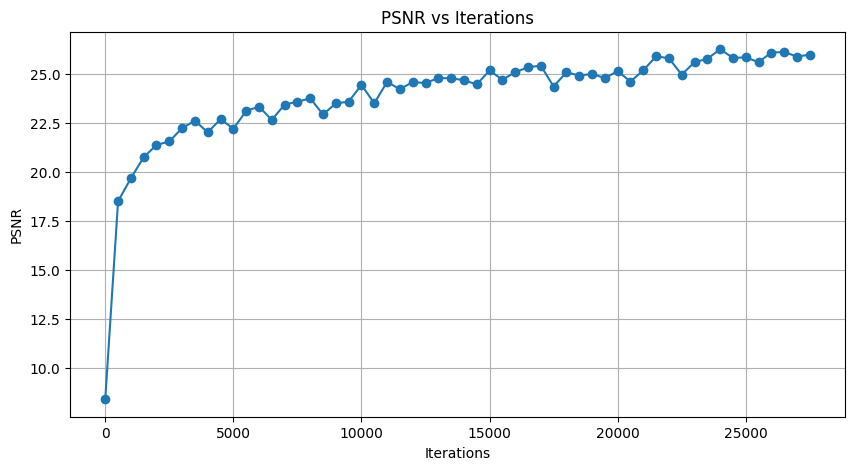

Iteration 27600: Loss 0.003318433417007327, Time per iter: 28.34s, Estimated time remaining: 68013.09s
Iteration 27700: Loss 0.0008233188418671489, Time per iter: 14.22s, Estimated time remaining: 32705.20s
Iteration 27800: Loss 0.0019159376388415694, Time per iter: 14.23s, Estimated time remaining: 31297.63s
Iteration 27900: Loss 0.0023854593746364117, Time per iter: 14.24s, Estimated time remaining: 29903.08s
Iteration 28000: Loss 0.0018863806035369635, Time per iter: 14.21s, Estimated time remaining: 28425.15s


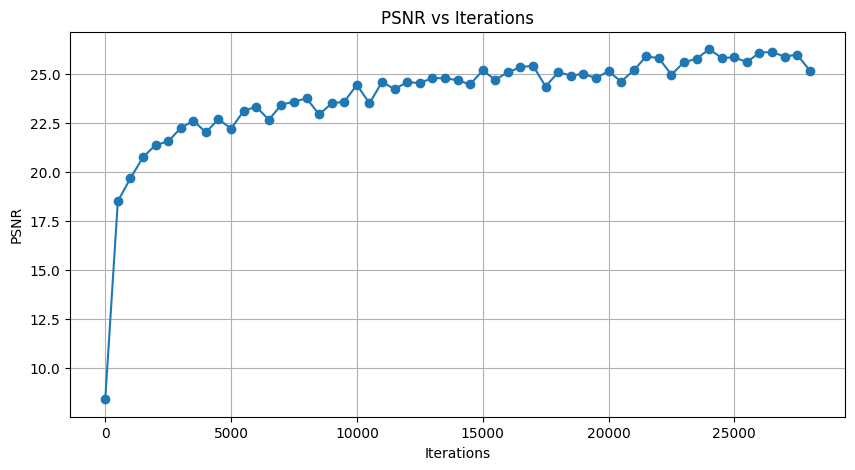

Iteration 28100: Loss 0.0009823883883655071, Time per iter: 28.39s, Estimated time remaining: 53940.34s
Iteration 28200: Loss 0.003317610826343298, Time per iter: 14.19s, Estimated time remaining: 25543.03s
Iteration 28300: Loss 0.0027079847641289234, Time per iter: 14.20s, Estimated time remaining: 24132.99s
Iteration 28400: Loss 0.0021415692754089832, Time per iter: 14.20s, Estimated time remaining: 22719.87s
Iteration 28500: Loss 0.002239770023152232, Time per iter: 14.20s, Estimated time remaining: 21301.20s


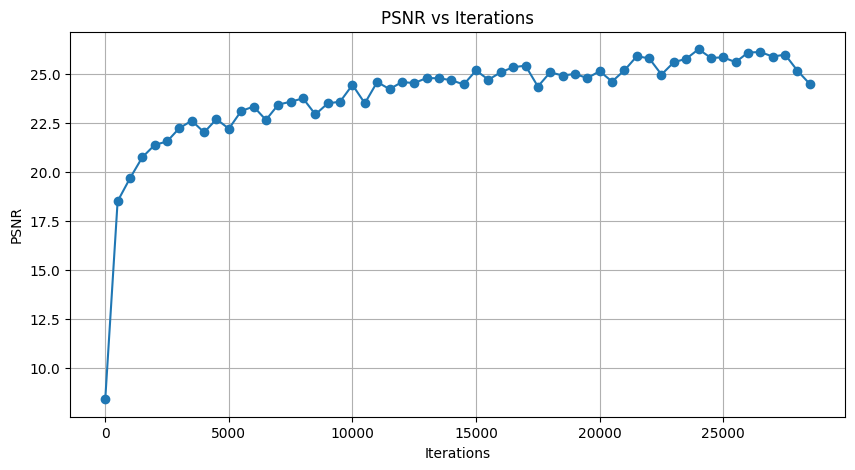

Iteration 28600: Loss 0.001814384711906314, Time per iter: 28.33s, Estimated time remaining: 39668.92s
Iteration 28700: Loss 0.001806665095500648, Time per iter: 14.18s, Estimated time remaining: 18434.13s
Iteration 28800: Loss 0.0035246768966317177, Time per iter: 14.20s, Estimated time remaining: 17039.76s
Iteration 28900: Loss 0.002404438331723213, Time per iter: 14.20s, Estimated time remaining: 15624.25s
Iteration 29000: Loss 0.003966568037867546, Time per iter: 14.21s, Estimated time remaining: 14209.82s


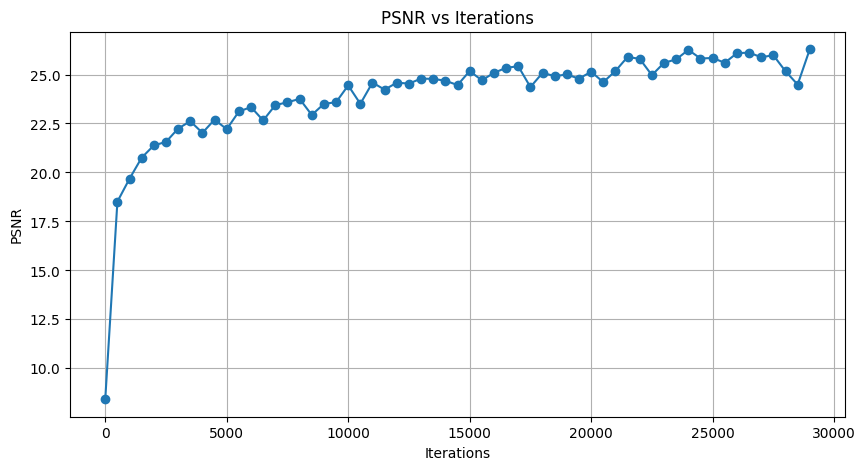

Iteration 29100: Loss 0.0028297973331063986, Time per iter: 28.43s, Estimated time remaining: 25586.19s
Iteration 29200: Loss 0.002883650129660964, Time per iter: 14.16s, Estimated time remaining: 11324.40s
Iteration 29300: Loss 0.0022550050634890795, Time per iter: 14.18s, Estimated time remaining: 9922.87s
Iteration 29400: Loss 0.0038781536277383566, Time per iter: 14.18s, Estimated time remaining: 8509.00s
Iteration 29500: Loss 0.0023502008989453316, Time per iter: 14.18s, Estimated time remaining: 7091.83s


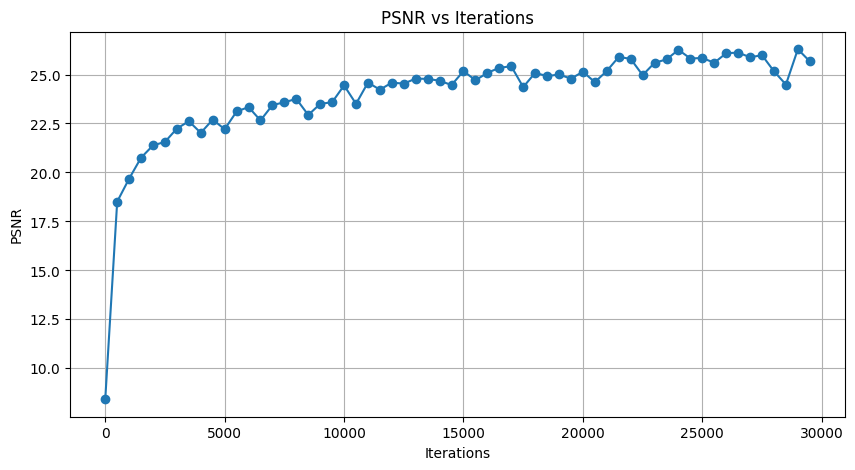

Iteration 29600: Loss 0.004344040062278509, Time per iter: 28.42s, Estimated time remaining: 11367.19s
Iteration 29700: Loss 0.0036970432847738266, Time per iter: 14.28s, Estimated time remaining: 4283.23s
Iteration 29800: Loss 0.0019439652096480131, Time per iter: 14.56s, Estimated time remaining: 2911.47s
Iteration 29900: Loss 0.0026575117371976376, Time per iter: 14.31s, Estimated time remaining: 1431.13s


('coarse_nerf_model.pth', 'fine_nerf_model.pth')

In [2]:

# Initialize time variables
start_time = time.time()
prev_time = start_time

#training
for i in range(num_iters):
    # Randomly select an image from the dataset
    img_idx = np.random.randint(images.shape[0])
    target_img = images[img_idx]
    pose = tform_cam2world[img_idx]

    # Randomly select a batch of rays from the image
    batch_rows = np.random.choice(height, batch_size, replace=False)
    batch_cols = np.random.choice(width, batch_size, replace=False)
    target_img_batch = target_img[batch_rows][:, batch_cols]

    # Generate ray bundle for the selected subset
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, pose)
    ray_origins = ray_origins[batch_rows][:, batch_cols]
    ray_directions = ray_directions[batch_rows][:, batch_cols]

    # Compute query points for both coarse and fine networks
    coarse_query_points, coarse_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_coarse_samples, randomize=True
    )
    fine_query_points, fine_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_fine_samples, randomize=False
    )

    # Flatten and encode the query points
    coarse_query_points_flat = coarse_query_points.reshape((-1, 3))
    coarse_encoded_points = positional_encoding(coarse_query_points_flat)
    fine_query_points_flat = fine_query_points.reshape((-1, 3))
    fine_encoded_points = positional_encoding(fine_query_points_flat)

    # Forward pass through the coarse and fine networks
    coarse_radiance_field = coarse_net(coarse_encoded_points)
    fine_radiance_field = fine_net(fine_encoded_points)

    # Compute the rendered RGB maps, depth maps, and accumulation maps using the correct depth values
    coarse_rgb_map, _, coarse_acc_map = render_volume_density(
        coarse_radiance_field.reshape(tuple(coarse_query_points.shape[:-1]) + (4,)),
        ray_origins,
        coarse_depth_values
    )
    fine_rgb_map, _, _ = render_volume_density(
        fine_radiance_field.reshape(tuple(fine_query_points.shape[:-1]) + (4,)),
        ray_origins,
        fine_depth_values
    )

    # Combine the coarse and fine RGB maps
    rgb_map = coarse_rgb_map * (1. - coarse_acc_map[..., None]) + fine_rgb_map

    # Compute the loss as the mean squared error between the rendered and target images
    loss = ((rgb_map - target_img_batch) ** 2).mean()
    losses.append(loss.item())

    # Backpropagate the loss and update the model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss, time per iteration, and estimated time remaining for every 100 iterations
    if i % 100 == 0:
        current_time = time.time()
        time_per_iter = current_time - prev_time
        estimated_time_remaining = time_per_iter * (num_iters - i)
        print(f"Iteration {i}: Loss {loss.item()}, Time per iter: {time_per_iter:.2f}s, Estimated time remaining: {estimated_time_remaining:.2f}s")
        prev_time = current_time

    # Calculate and store PSNR for every 500 iterations
    if i % 500 == 0:
        with torch.no_grad():
            rendered_img = render_novel_view(coarse_net, fine_net, testpose)
            psnr_val = psnr(testimg.cpu().numpy(), rendered_img.cpu().numpy())
            psnr_values.append(psnr_val)
            iterations.append(i)

        # Plotting the PSNR graph
        plt.figure(figsize=(10, 5))
        plt.plot(iterations, psnr_values, '-o')
        plt.title("PSNR vs Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("PSNR")
        plt.grid(True)
        plt.show()

# Save the trained models for coarse_net and fine_net
coarse_save_path = "coarse_nerf_model.pth"
fine_save_path = "fine_nerf_model.pth"
torch.save(coarse_net.state_dict(), coarse_save_path)
torch.save(fine_net.state_dict(), fine_save_path)

coarse_save_path, fine_save_path



In [8]:
# Define the target image for pose optimization
target_img = images[target_img_index]
torch.cuda.empty_cache()

# Pose Optimization Loop
for step in range(num_pose_optimization_steps):
    # Generate ray bundle for the entire image using the current pose
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, initial_pose)
    
    # Compute query points for both coarse and fine networks
    coarse_query_points, coarse_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_coarse_samples, randomize=True
    )
    fine_query_points, fine_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_fine_samples, randomize=False
    )

    # Flatten and encode the query points
    coarse_query_points_flat = coarse_query_points.reshape((-1, 3))
    coarse_encoded_points = positional_encoding(coarse_query_points_flat)
    fine_query_points_flat = fine_query_points.reshape((-1, 3))
    fine_encoded_points = positional_encoding(fine_query_points_flat)

    # Forward pass through the coarse and fine networks
    coarse_radiance_field = coarse_net(coarse_encoded_points)
    fine_radiance_field = fine_net(fine_encoded_points)

    # Compute the rendered RGB maps, depth maps, and accumulation maps using the correct depth values
    coarse_rgb_map, _, coarse_acc_map = render_volume_density(
        coarse_radiance_field.reshape(tuple(coarse_query_points.shape[:-1]) + (4,)),
        ray_origins,
        coarse_depth_values
    )
    fine_rgb_map, _, _ = render_volume_density(
        fine_radiance_field.reshape(tuple(fine_query_points.shape[:-1]) + (4,)),
        ray_origins,
        fine_depth_values
    )

    # Combine the coarse and fine RGB maps
    rendered_img = coarse_rgb_map * (1. - coarse_acc_map[..., None]) + fine_rgb_map

    # Compute the loss
    loss = pose_loss_fn(rendered_img, target_img)

    # Backpropagate the loss and update the pose
    pose_optimizer.zero_grad()
    loss.backward()
    pose_optimizer.step()

    # Print the loss every 10 steps
    if step % 10 == 0:
        print(f"Step [{step}/{num_pose_optimization_steps}]: Loss: {loss.item()}")

# After optimization, visualize the rendered image and the target image
with torch.no_grad():
    # Render the image using the optimized pose
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, initial_pose)
    coarse_query_points, coarse_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_coarse_samples, randomize=True
    )
    fine_query_points, fine_depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_fine_samples, randomize=False
    )
    coarse_query_points_flat = coarse_query_points.reshape((-1, 3))
    coarse_encoded_points = positional_encoding(coarse_query_points_flat)
    fine_query_points_flat = fine_query_points.reshape((-1, 3))
    fine_encoded_points = positional_encoding(fine_query_points_flat)
    coarse_radiance_field = coarse_net(coarse_encoded_points)
    fine_radiance_field = fine_net(fine_encoded_points)
    coarse_rgb_map, _, coarse_acc_map = render_volume_density(
        coarse_radiance_field.reshape(tuple(coarse_query_points.shape[:-1]) + (4,)),
        ray_origins,
        coarse_depth_values
    )
    fine_rgb_map, _, _ = render_volume_density(
        fine_radiance_field.reshape(tuple(fine_query_points.shape[:-1]) + (4,)),
        ray_origins,
        fine_depth_values
    )
    rendered_img = coarse_rgb_map * (1. - coarse_acc_map[..., None]) + fine_rgb_map

    # Display the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rendered_img.cpu().numpy())
    plt.title("Rendered Image")
    plt.subplot(1, 2, 2)
    plt.imshow(target_img.cpu().numpy())
    plt.title("Target Image")
    plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 6.00 GiB total capacity; 11.80 GiB already allocated; 0 bytes free; 11.89 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF